# Excess inflation and asset class returns

This notebook serves as an illustration of the points discussed in the post ["Excess inflation and asset class returns"](https://research.macrosynergy.com/excess-inflation-and-asset-class-returns/) available on the Macrosynergy website. 

Excess inflation means consumer price trends over and above the inflation target. In a credible inflation targeting regime, positive excess inflation skews the balance of risks of monetary policy towards tightening. An inflation shortfall tips the risk balance towards easing. Assuming that these shifting balances are not always fully priced by the market, excess inflation in a local currency area should negatively predict local rates market and equity market returns, and positively local-currency FX returns. Indeed, these hypotheses are strongly supported by empirical evidence for 10 developed markets since 2000. For fixed income and FX excess inflation has not just been a directional but also a relative cross-country trading signal. The deployment of excess inflation as a trading signal across asset classes has added notable economic value.

This notebook provides the essential code required to replicate the analysis discussed in the post.  

The notebook covers the three main parts:

- Get Packages and JPMaQS Data: This section is responsible for installing and importing the necessary Python packages that are used throughout the analysis. 

- Transformations and Checks: In this part, the notebook performs various calculations and transformations on the data to derive the relevant signals and targets used for the analysis, including excess inflation indicators, effective excess inflation, relative excess inflation, and other metrics or ratios used in the analysis.

- Value Checks: This is the most critical section, where the notebook calculates and implements the trading strategies based on the hypotheses tested in the post. Depending on the analysis, this section involves backtesting various trading strategies targeting fixed income, equity, and FX returns. The strategies  utilize the excess inflation indicators and other signals derived in the previous section.

It's important to note that while the notebook covers a selection of indicators and strategies used for the post's main findings, there are countless other possible indicators and approaches that can be explored by users, as mentioned in the post. Users can modify the code to test different hypotheses and strategies based on their own research and ideas. Best of luck with your research!

## Get packages and JPMaQS data

This notebook primarily relies on the standard packages available in the Python data science stack. However, there is an additional package `macrosynergy` that is required for two purposes:

- Downloading JPMaQS data: The `macrosynergy` package facilitates the retrieval of JPMaQS data, which is used in the notebook.

- For the analysis of quantamental data and value propositions: The `macrosynergy` package provides functionality for performing quick analyses of quantamental data and exploring value propositions.

For detailed information and a comprehensive understanding of the `macrosynergy` package and its functionalities, please refer to the [“Introduction to Macrosynergy package”](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php) notebook on the Macrosynergy Quantamental Academy or visit the following link on [Kaggle](https://www.kaggle.com/code/macrosynergy/introduction-to-macrosynergy-package).

In [ ]:
# Run only if needed!
"""!pip install macrosynergy --upgrade"""

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import macrosynergy.management as msm
import macrosynergy.panel as msp
import macrosynergy.signal as mss
import macrosynergy.pnl as msn

from macrosynergy.download import JPMaQSDownload

import warnings

warnings.simplefilter("ignore")

The JPMaQS indicators we consider are downloaded using the J.P. Morgan Dataquery API interface within the `macrosynergy` package. This is done by specifying ticker strings, formed by appending an indicator category code <category> to a currency area code <cross_section>. These constitute the main part of a full quantamental indicator ticker, taking the form `DB(JPMAQS,<cross_section>_<category>,<info>)`, where <info> denotes the time series of information for the given cross-section and category. The following types of information are available:

`value` giving the latest available values for the indicator
`eop_lag` referring to days elapsed since the end of the observation period
`mop_lag` referring to the number of days elapsed since the mean observation period
`grade` denoting a grade of the observation, giving a metric of real-time information quality.

After instantiating the `JPMaQSDownload` class within the `macrosynergy.download` module, one can use the `download(tickers,start_date,metrics)` method to easily download the necessary data, where `tickers` is an array of ticker strings, `start_date` is the first collection date to be considered and `metrics` is an array comprising the times series information to be downloaded. For more information see [here](https://github.com/macrosynergy/macrosynergy/blob/develop/README.md).

In [3]:
# Cross-sections

cids_g3 = ["EUR", "JPY", "USD"]


# Equity cross-sections lists

cids_dmsc_eq = ["AUD", "CAD", "CHF", "GBP", "SEK"]
cids_latm_eq = ["BRL", "MXN"]  # Latam
cids_emea_eq = ["PLN", "TRY", "ZAR"]  # EMEA
cids_emas_eq = ["CNY", "HKD", "INR", "KRW", "MYR", "SGD", "THB", "TWD"]

cids_dmeq = cids_g3 + cids_dmsc_eq
cids_emeq = cids_latm_eq + cids_emea_eq + cids_emas_eq
cids_eq = cids_dmeq + cids_emeq

# IRS cross section lists

cids_dmsc_du = ["AUD", "CAD", "CHF", "GBP", "NOK", "NZD", "SEK"]
cids_latm_du = ["CLP", "COP", "MXN"]  # Latam
cids_emea_du = ["CZK", "HUF", "ILS", "PLN", "RON", "RUB", "TRY", "ZAR"]  # EMEA
cids_emas_du = ["CNY", "HKD", "IDR", "INR", "KRW", "MYR", "SGD", "THB", "TWD"]

cids_dmdu = cids_g3 + cids_dmsc_du
cids_emdu = cids_latm_du + cids_emea_du + cids_emas_du
cids_du = cids_dmdu + cids_emdu

# FX cross-section lists

cids_dmsc_fx = [
    "AUD",
    "CAD",
    "CHF",
    "GBP",
    "NOK",
    "NZD",
    "SEK",
]  # DM small currency areas

cids_dmfx = ["JPY"] + cids_dmsc_fx

cids_fx = cids_dmfx + [
    "BRL",
    "COP",
    "CLP",
    "MXN",
    "PEN",
    "CZK",
    "HUF",
    "ILS",
    "PLN",
    "RON",
    "RUB",
    "TRY",
    "ZAR",
    "IDR",
    "INR",
    "KRW",
    "MYR",
    "PHP",
    "THB",
    "TWD",
]

cids_eur = ["CHF", "CZK", "HUF", "NOK", "PLN", "RON", "SEK"]  # trading against EUR
cids_eud = ["GBP", "RUB", "TRY"]  # trading against EUR and USD
cids_usd = list(set(cids_fx) - set(cids_eur + cids_eud))  # trading against USD


# Total

cids = list(set(cids_eq + cids_du + cids_fx))
cids.sort()

Please see the [post](https://research.macrosynergy.com/excess-inflation-and-asset-class-returns/) for the rationale for the choice of particular inflation indicators. We focus here on core CPI, whereby "core" means excluding volatile items, such as food and energy, seasonally and (mostly) jump-adjusted. These are standard adjustments used in most economic analysis. We have included the links to all category pages below with tickers, descriptions, calculation details, notes, example download code, availability, basic statistics, and timelines. 

In [4]:
# Categories

main = [
    "CPIXFE_SA_P1M1ML12",  # Consistent core CPI inflation, %oya
    "CPIC_SJA_P6M6ML6AR",  # Adjusted latest core consumer price trend, seasonally and jump-adjusted: % 6m/6m ar
    "CPIXFE_SJA_P6M6ML6AR",  # Consistent core CPI trend, seasonally and jump-adjusted: % 3m/3m ar / % 6m/6m ar.
    "INFE2Y_JA",  # Estimated 2-years ahead inflation expectations (Macrosynergy method)
    "INFTEFF_NSA",  #  Effective official inflation target (Macrosynergy method), % over a year ago.
    "INFTARGET_NSA",
]  # Estimated extended official target for next year, % over a year ago.


rets = ["FXTARGETED_NSA", "FXUNTRADABLE_NSA", "FXXR_VT10", "EQXR_VT10", "DU02YXR_VT10"]

xcats = main + rets

tickers = [cid + "_" + xcat for cid in cids for xcat in xcats]
print(f"Maximum number of tickers is {len(tickers)}")

Maximum number of tickers is 363


JPMaQS indicators are conveniently grouped into 6 main categories: Economic Trends, Macroeconomic balance sheets, Financial conditions, Shocks and risk measures, Stylized trading factors, and Generic returns. Each indicator has a separate page with notes, description, availability, statistical measures, and timelines for main currencies. The description of each JPMaQS category is available under [Macro quantamental academy](https://academy.macrosynergy.com/quantamental-indicators/). For tickers used in this notebook see [Consumer price inflation trends](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Consumer%20price%20inflation%20trends.php), [Consistent core CPI trends](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Consistent%20core%20CPI%20trends.php), [Inflation targets](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Inflation%20targets.php), [Inflation expectations (Macrosynergy method)](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Inflation%20expectations.php), [FX tradeability and flexibility](https://academy.macrosynergy.com/academy/Themes/Stylized%20trading%20factors/_build/html/notebooks/FX%20tradeability%20and%20flexibility.php), [FX forward returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/FX%20forward%20returns.php), [Equity index future returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Equity%20index%20future%20returns.php), and [Duration returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Duration%20returns.php).

In [5]:
start_date = "2000-01-01"

# Retrieve credentials

client_id: str = os.getenv("DQ_CLIENT_ID")
client_secret: str = os.getenv("DQ_CLIENT_SECRET")

with JPMaQSDownload(client_id=client_id, client_secret=client_secret) as dq:
    df = dq.download(
        tickers=tickers,
        start_date=start_date,
        suppress_warning=True,
        metrics=["all"],
        report_time_taken=True,
        show_progress=True,
    )

Timestamp UTC:  2024-03-21 14:06:22
Connection successful!


Requesting data: 100%|██████████| 73/73 [00:16<00:00,  4.49it/s]


Time taken to download data: 	36.97 seconds.
Some expressions are missing from the downloaded data. Check logger output for complete list.
104 out of 1452 expressions are missing. To download the catalogue of all available expressions and filter the unavailable expressions, set `get_catalogue=True` in the call to `JPMaQSDownload.download()`.
Some dates are missing from the downloaded data. 
2 out of 6321 dates are missing.


### Availability

It is important to assess data availability before conducting any analysis. It allows identifying any potential gaps or limitations in the dataset, which can impact the validity and reliability of analysis and ensure that a sufficient number of observations for each selected category and cross-section is available as well as determining the appropriate time periods for analysis. 

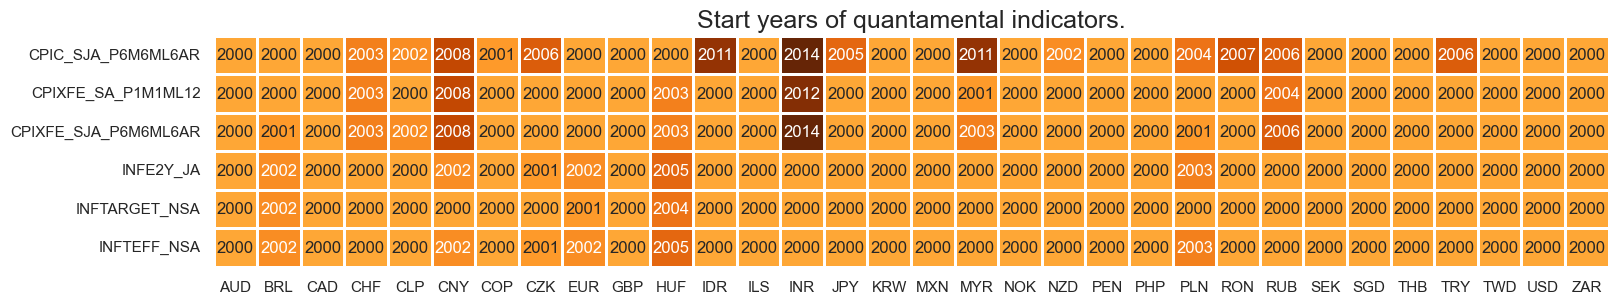

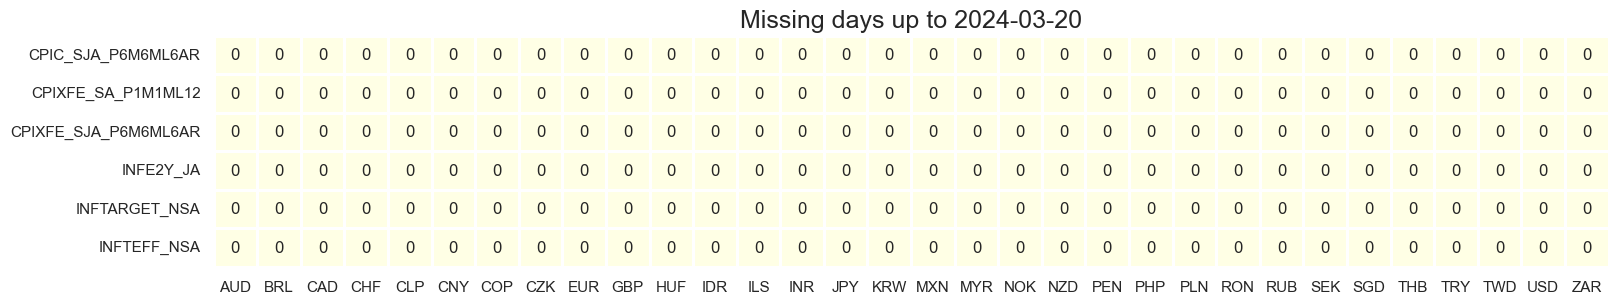

In [6]:
msm.check_availability(df, xcats=main, cids=cids)

### Blacklist dictionary

Identifying and isolating periods of official exchange rate targets, illiquidity, or convertibility-related distortions in FX markets is the first step in creating an FX trading strategy. These periods can significantly impact the behavior and dynamics of currency markets, and failing to account for them can lead to inaccurate or misleading findings. [`make_blacklist()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#exclude-series-sections-with-make-blacklist) helper function from the `macrysynergy` package creates a standardized dictionary of blacklist periods, which can then be passed to other functions. As indicators for blacklisting, we use FX tradeability and flexibility (f.e. periods when currency is pegged or FX market is distorted) 

In [7]:
dfb = df[df["xcat"].isin(["FXTARGETED_NSA", "FXUNTRADABLE_NSA"])].loc[
    :, ["cid", "xcat", "real_date", "value"]
]
dfba = (
    dfb.groupby(["cid", "real_date"])
    .aggregate(value=pd.NamedAgg(column="value", aggfunc="max"))
    .reset_index()
)
dfba["xcat"] = "FXBLACK"
fxblack = msp.make_blacklist(dfba, "FXBLACK")
fxblack

{'BRL': (Timestamp('2012-12-03 00:00:00'), Timestamp('2013-09-30 00:00:00')),
 'CHF': (Timestamp('2011-10-03 00:00:00'), Timestamp('2015-01-30 00:00:00')),
 'CNY': (Timestamp('2000-01-03 00:00:00'), Timestamp('2024-03-20 00:00:00')),
 'CZK': (Timestamp('2014-01-01 00:00:00'), Timestamp('2017-07-31 00:00:00')),
 'HKD': (Timestamp('2000-01-03 00:00:00'), Timestamp('2024-03-20 00:00:00')),
 'ILS': (Timestamp('2000-01-03 00:00:00'), Timestamp('2005-12-30 00:00:00')),
 'INR': (Timestamp('2000-01-03 00:00:00'), Timestamp('2004-12-31 00:00:00')),
 'MYR_1': (Timestamp('2000-01-03 00:00:00'), Timestamp('2007-11-30 00:00:00')),
 'MYR_2': (Timestamp('2018-07-02 00:00:00'), Timestamp('2024-03-20 00:00:00')),
 'PEN': (Timestamp('2021-07-01 00:00:00'), Timestamp('2021-07-30 00:00:00')),
 'RON': (Timestamp('2000-01-03 00:00:00'), Timestamp('2005-11-30 00:00:00')),
 'RUB_1': (Timestamp('2000-01-03 00:00:00'), Timestamp('2005-11-30 00:00:00')),
 'RUB_2': (Timestamp('2022-02-01 00:00:00'), Timestamp('20

## Transformations and checks

### Features

#### Excess inflation ratios

In the cell below we create an excess inflation indicators as a difference between seasonally and jump-adjusted core consumer price trends, % 6m/6m ar (`CPIC_SJA_P6M6ML6AR`) and the official inflation target (`INFTARGETO_NSA`). We divide this difference by the official inflation target (`INFTARGET_NSA`). Additionally, the cell also calculates excess inflation indicators for "Consistent core CPI inflation" and the "Estimated 2-years ahead inflation expectation" using the Macrosynergy method. These new indicators  receive the `_XR` postfix to distinguish them from the original indicators. 

In [8]:
dfx = df.copy()
infs = [
    "CPIXFE_SA_P1M1ML12",
    "CPIC_SJA_P6M6ML6AR",
    "CPIXFE_SJA_P6M6ML6AR",
    "INFE2Y_JA",
]
bm = "INFTARGET_NSA"  # benchmark that is subtracted form inflation
dn = "INFTARGET_NSA"  # denominator used for ratio

calcs = []
for inf in infs:
    calcs += [f"{inf}_XR = ( {inf} - {bm} ) / {dn} "]

dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cids, blacklist=None)
dfx = msm.update_df(dfx, dfa)

The resulting excess inflation indicators are displayed for comparison with the help of customized function [`view_timelines()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-time-series-with-view-timelines) from the `macrosynergy` package:

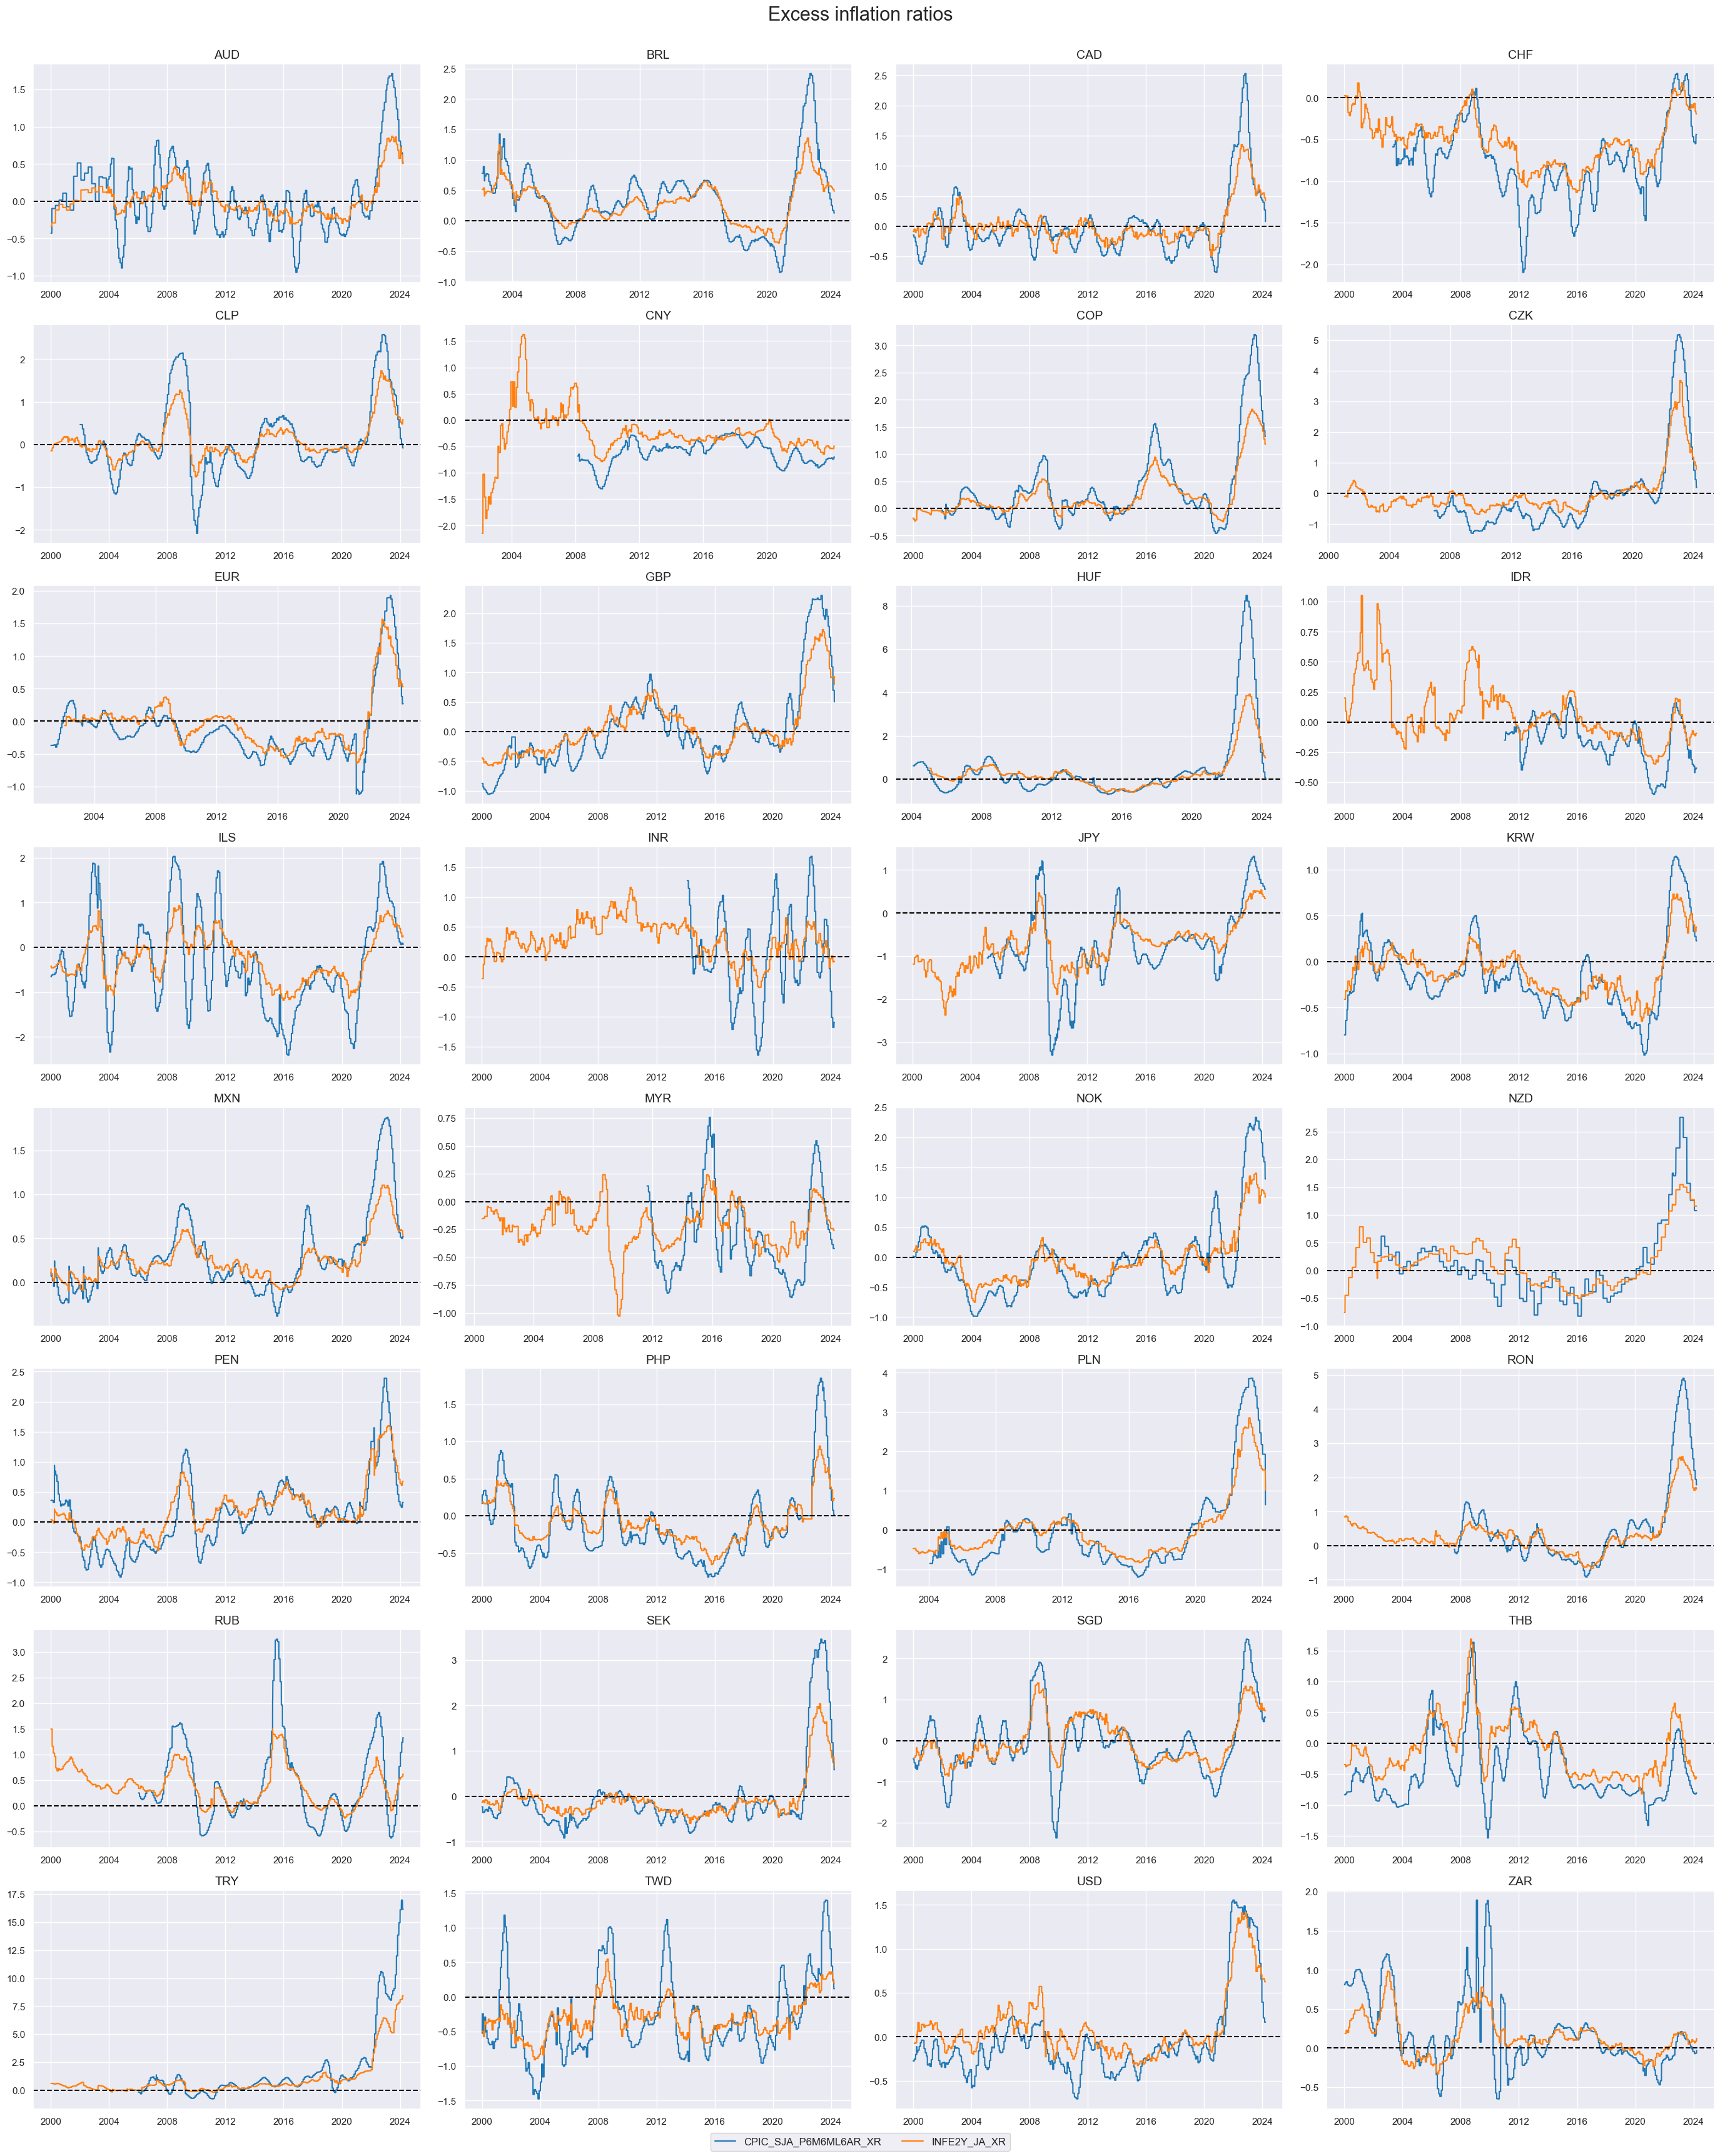

In [9]:
xcats_sel = ["CPIC_SJA_P6M6ML6AR_XR", "INFE2Y_JA_XR"]
sdate = "2000-01-01"

msp.view_timelines(
    dfx,
    xcats=xcats_sel,
    cids=cids,
    ncol=4,
    cumsum=False,
    start=sdate,
    same_y=False,
    size=(12, 12),
    all_xticks=True,
    title_fontsize=22,
    title="Excess inflation ratios",
    xcat_labels=None,
)

#### Effective excess inflation ratios

Here we create another group of excess inflation indicators. This time we take the difference between inflation indicators and the _Effective inflation target_ ([`INFTEFF_NSA`](https://academy.macrosynergy.com/academy/Themes/Economic%20trends/_build/html/notebooks/Inflation%20targets.php?highlight=infteff)). We divide this difference by the official inflation target as above (`INFTARGETO_NSA`). The new indicators receive postfix `_EXR` to distinguish them from the original indicators. 

In [10]:
infs = [
    "CPIXFE_SA_P1M1ML12",
    "CPIC_SJA_P6M6ML6AR",
    "CPIXFE_SJA_P6M6ML6AR",
    "INFE2Y_JA",
]
bm = "INFTEFF_NSA"  # benchmark that is subtracted from inflation
dn = "INFTARGET_NSA"  # denominator used for ratio

calcs = []
for inf in infs:
    calcs += [f"{inf}_EXR = ( {inf} - {bm} ) / {dn} "]

dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cids, blacklist=None)
dfx = msm.update_df(dfx, dfa)

#### Relative excess inflation versus duration basket

From previously calculated excess inflation ratio with postfix `_XR` and effective excess inflation ratio with postfix `_EXR` we calculate relative excess inflation indicators versus duration basket, i.e. we subtract the basket average from these indicators. As basket we use major world currencies ['EUR', 'JPY', 'USD', 'AUD', 'CAD', 'CHF', 'GBP', 'NOK', 'NZD', 'SEK']. The new values receive postfix `_vDMDU`. This is done with the function [`make_relative_value()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#compute-panels-versus-basket-with-make-relative-value) from the `macrosynergy` package:

In [11]:
xcatx = [inf + "_" + xr for inf in infs for xr in ["XR", "EXR"]]

dfa = msp.make_relative_value(dfx, xcats=xcatx, cids=cids_dmdu, postfix="vDMDU")
dfx = msm.update_df(dfx, dfa)

The resulting relative excess inflation indicator and corresponding excess inflation indicator are displayed for comparison with the help of customized function [`view_timelines()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-time-series-with-view-timelines) from the `macrosynergy` package:

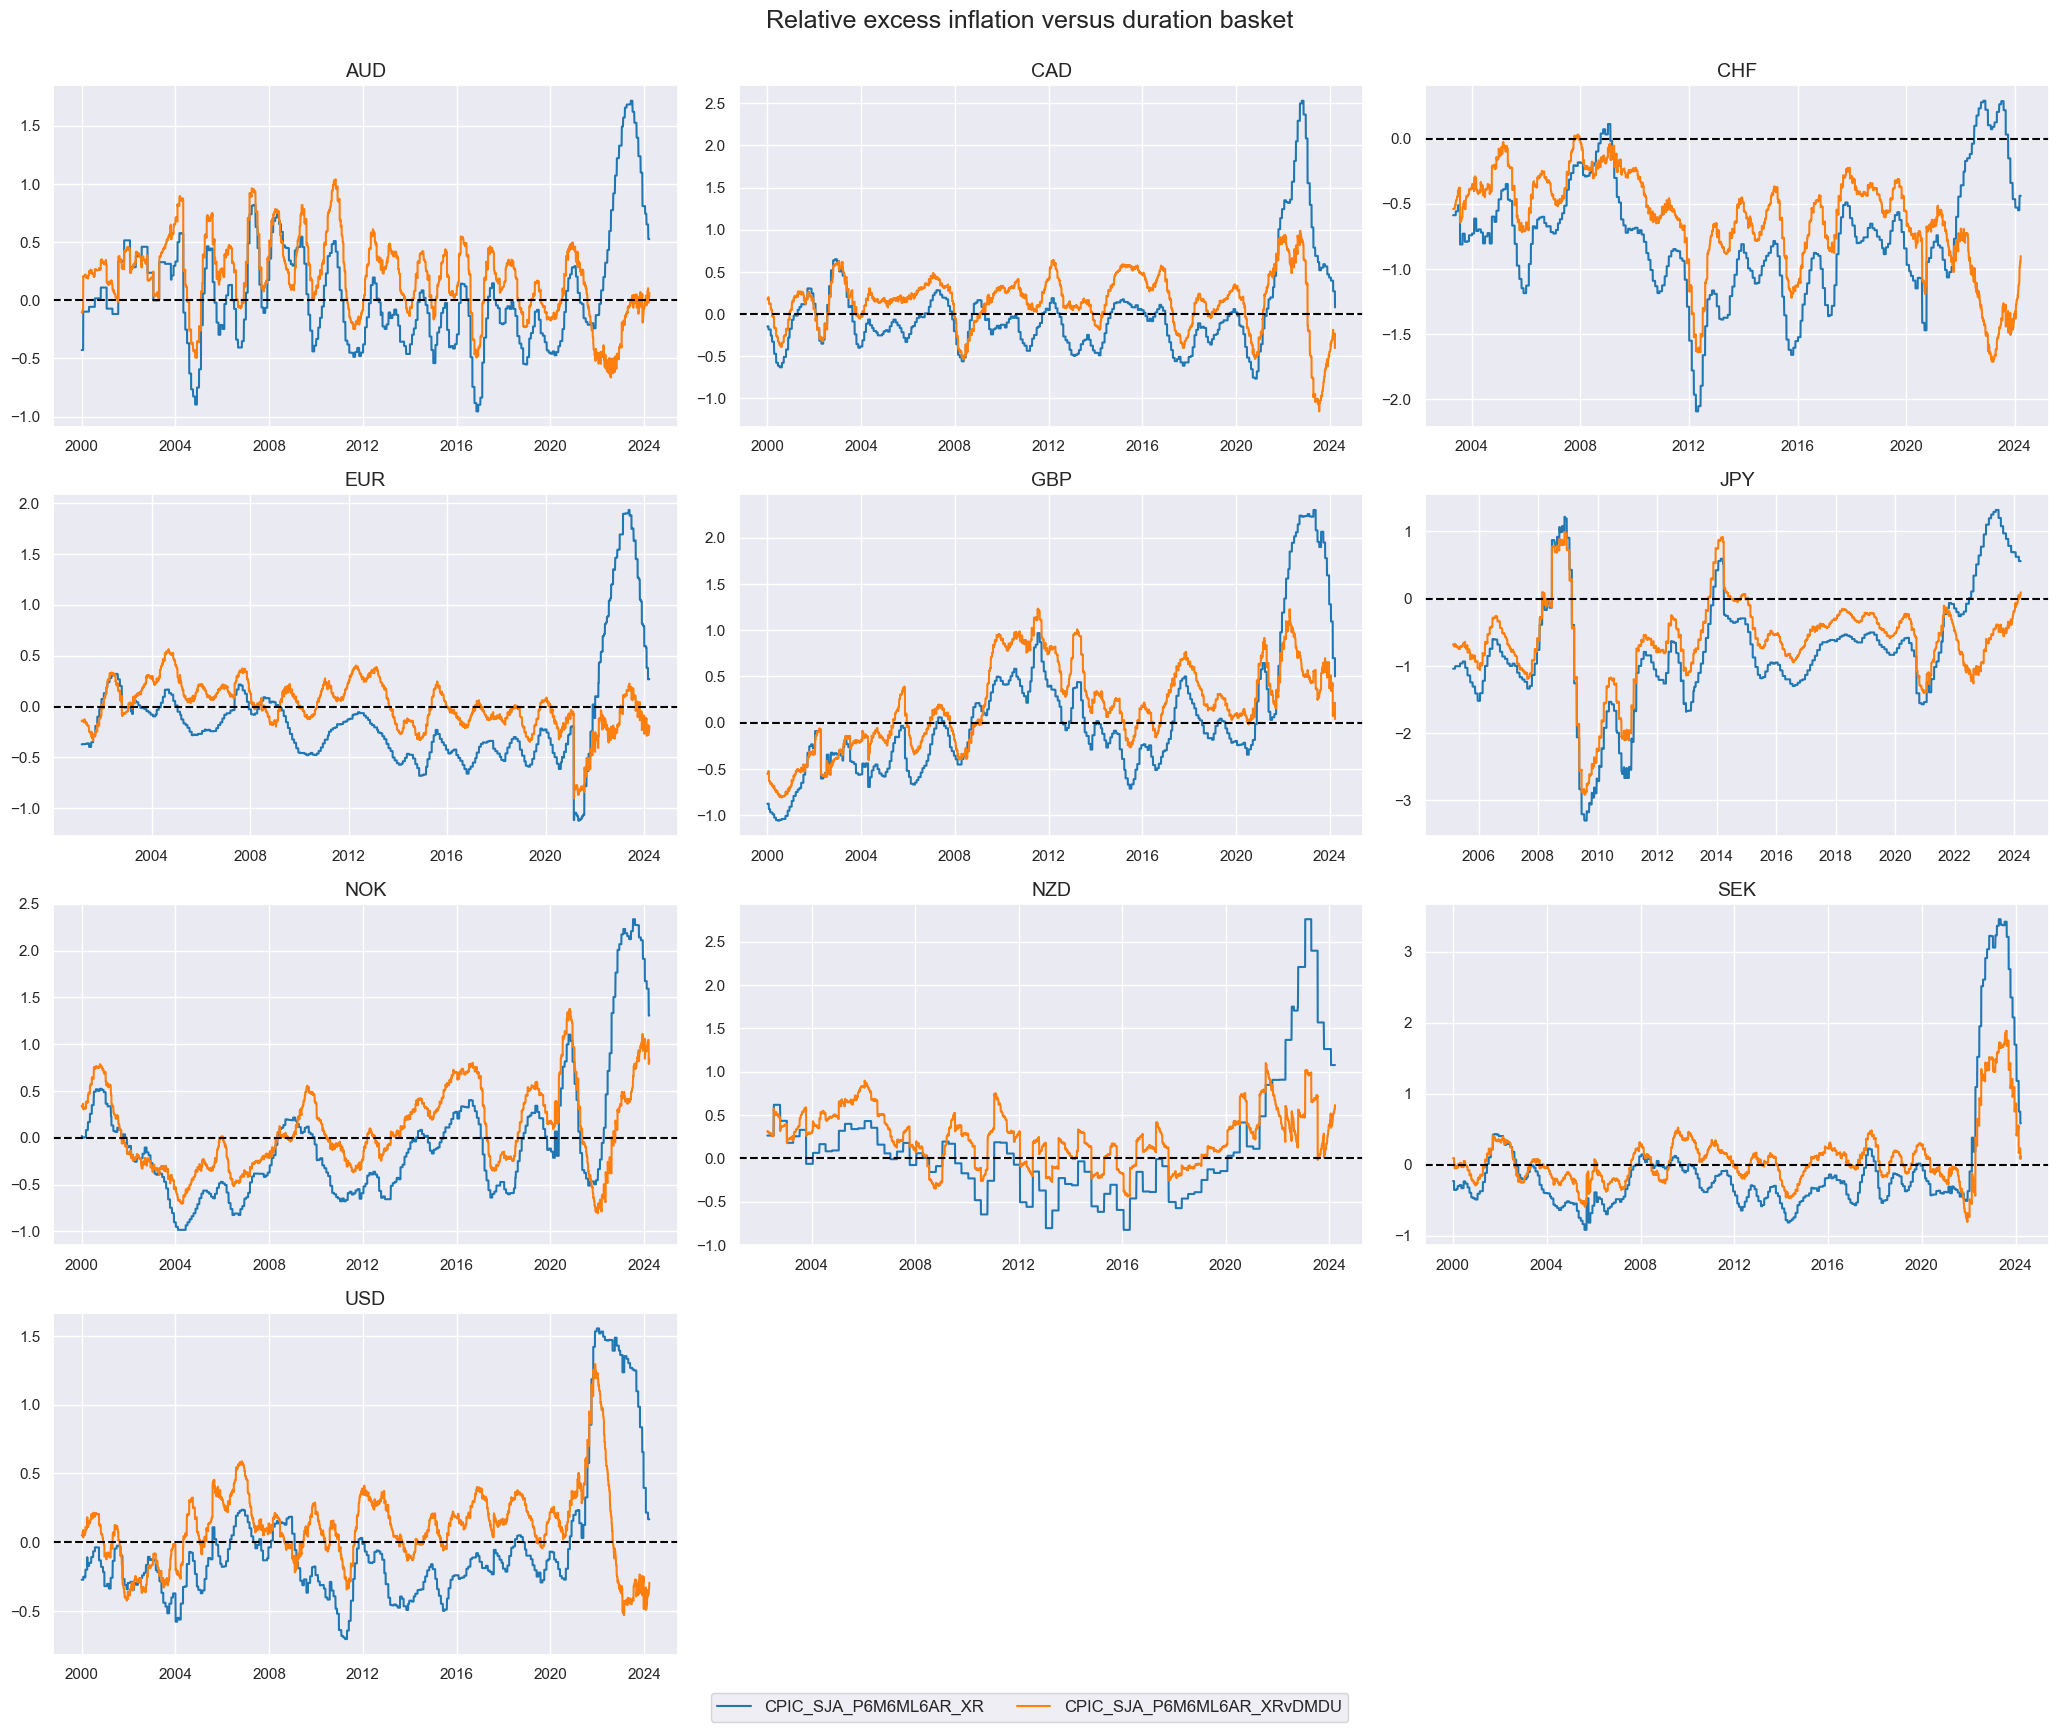

In [12]:
xcatx = ["CPIC_SJA_P6M6ML6AR_XR", "CPIC_SJA_P6M6ML6AR_XRvDMDU"]
sdate = "2000-01-01"
cidx = cids_dmdu


msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=3,
    cumsum=False,
    start=sdate,
    same_y=False,
    size=(12, 12),
    all_xticks=True,
    title_fontsize=18,
    title="Relative excess inflation versus duration basket",
    xcat_labels=None,
)

#### Excess inflation ratios versus FX benchmarks

We calculate excess inflation ratios versus FX benchmarks using `macrosynergy's` function ['panel_calculator()'](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#create-new-category-panels-with-panel-calculator). 

We calculate differentials to FX benchmarks for three types of currencies: those trading against USD, EUR and both USD and EUR. The list of currencies is as follows:

- Currencies traded against EUR:  ["CHF", "CZK", "HUF", "NOK", "PLN", "RON", "SEK"]  
- Currencies traded against USD and EUR: ["GBP", "RUB", "TRY"]. The benchmark equally weighs USD and EUR data
- Currencies traded against USD: all other currencies in our dataset

The resulting excess inflation ratios will get postfix `_vBM`

In [13]:
xcatx = [inf + "_" + xr for inf in infs for xr in ["XR", "EXR"]]

for xc in xcatx:
    calc_eur = [f"{xc}vBM = {xc} - iEUR_{xc}"]
    calc_usd = [f"{xc}vBM = {xc} - iUSD_{xc}"]
    calc_eud = [f"{xc}vBM = {xc} - 0.5 * ( iEUR_{xc} + iUSD_{xc} )"]

    dfa_eur = msp.panel_calculator(
        dfx,
        calcs=calc_eur,
        cids=cids_eur,
    )
    dfa_usd = msp.panel_calculator(
        dfx,
        calcs=calc_usd,
        cids=cids_usd,
    )
    dfa_eud = msp.panel_calculator(
        dfx,
        calcs=calc_eud,
        cids=cids_eud,
    )

    dfa = pd.concat([dfa_eur, dfa_usd, dfa_eud])
    dfx = msm.update_df(dfx, dfa)

To visualize the resulting Excess inflation ratios versus FX benchmarks indicators we again use the customized function [`view_timelines()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-time-series-with-view-timelines) from the `macrosynergy` package for two inflation indicators which we later use for generating trading signals

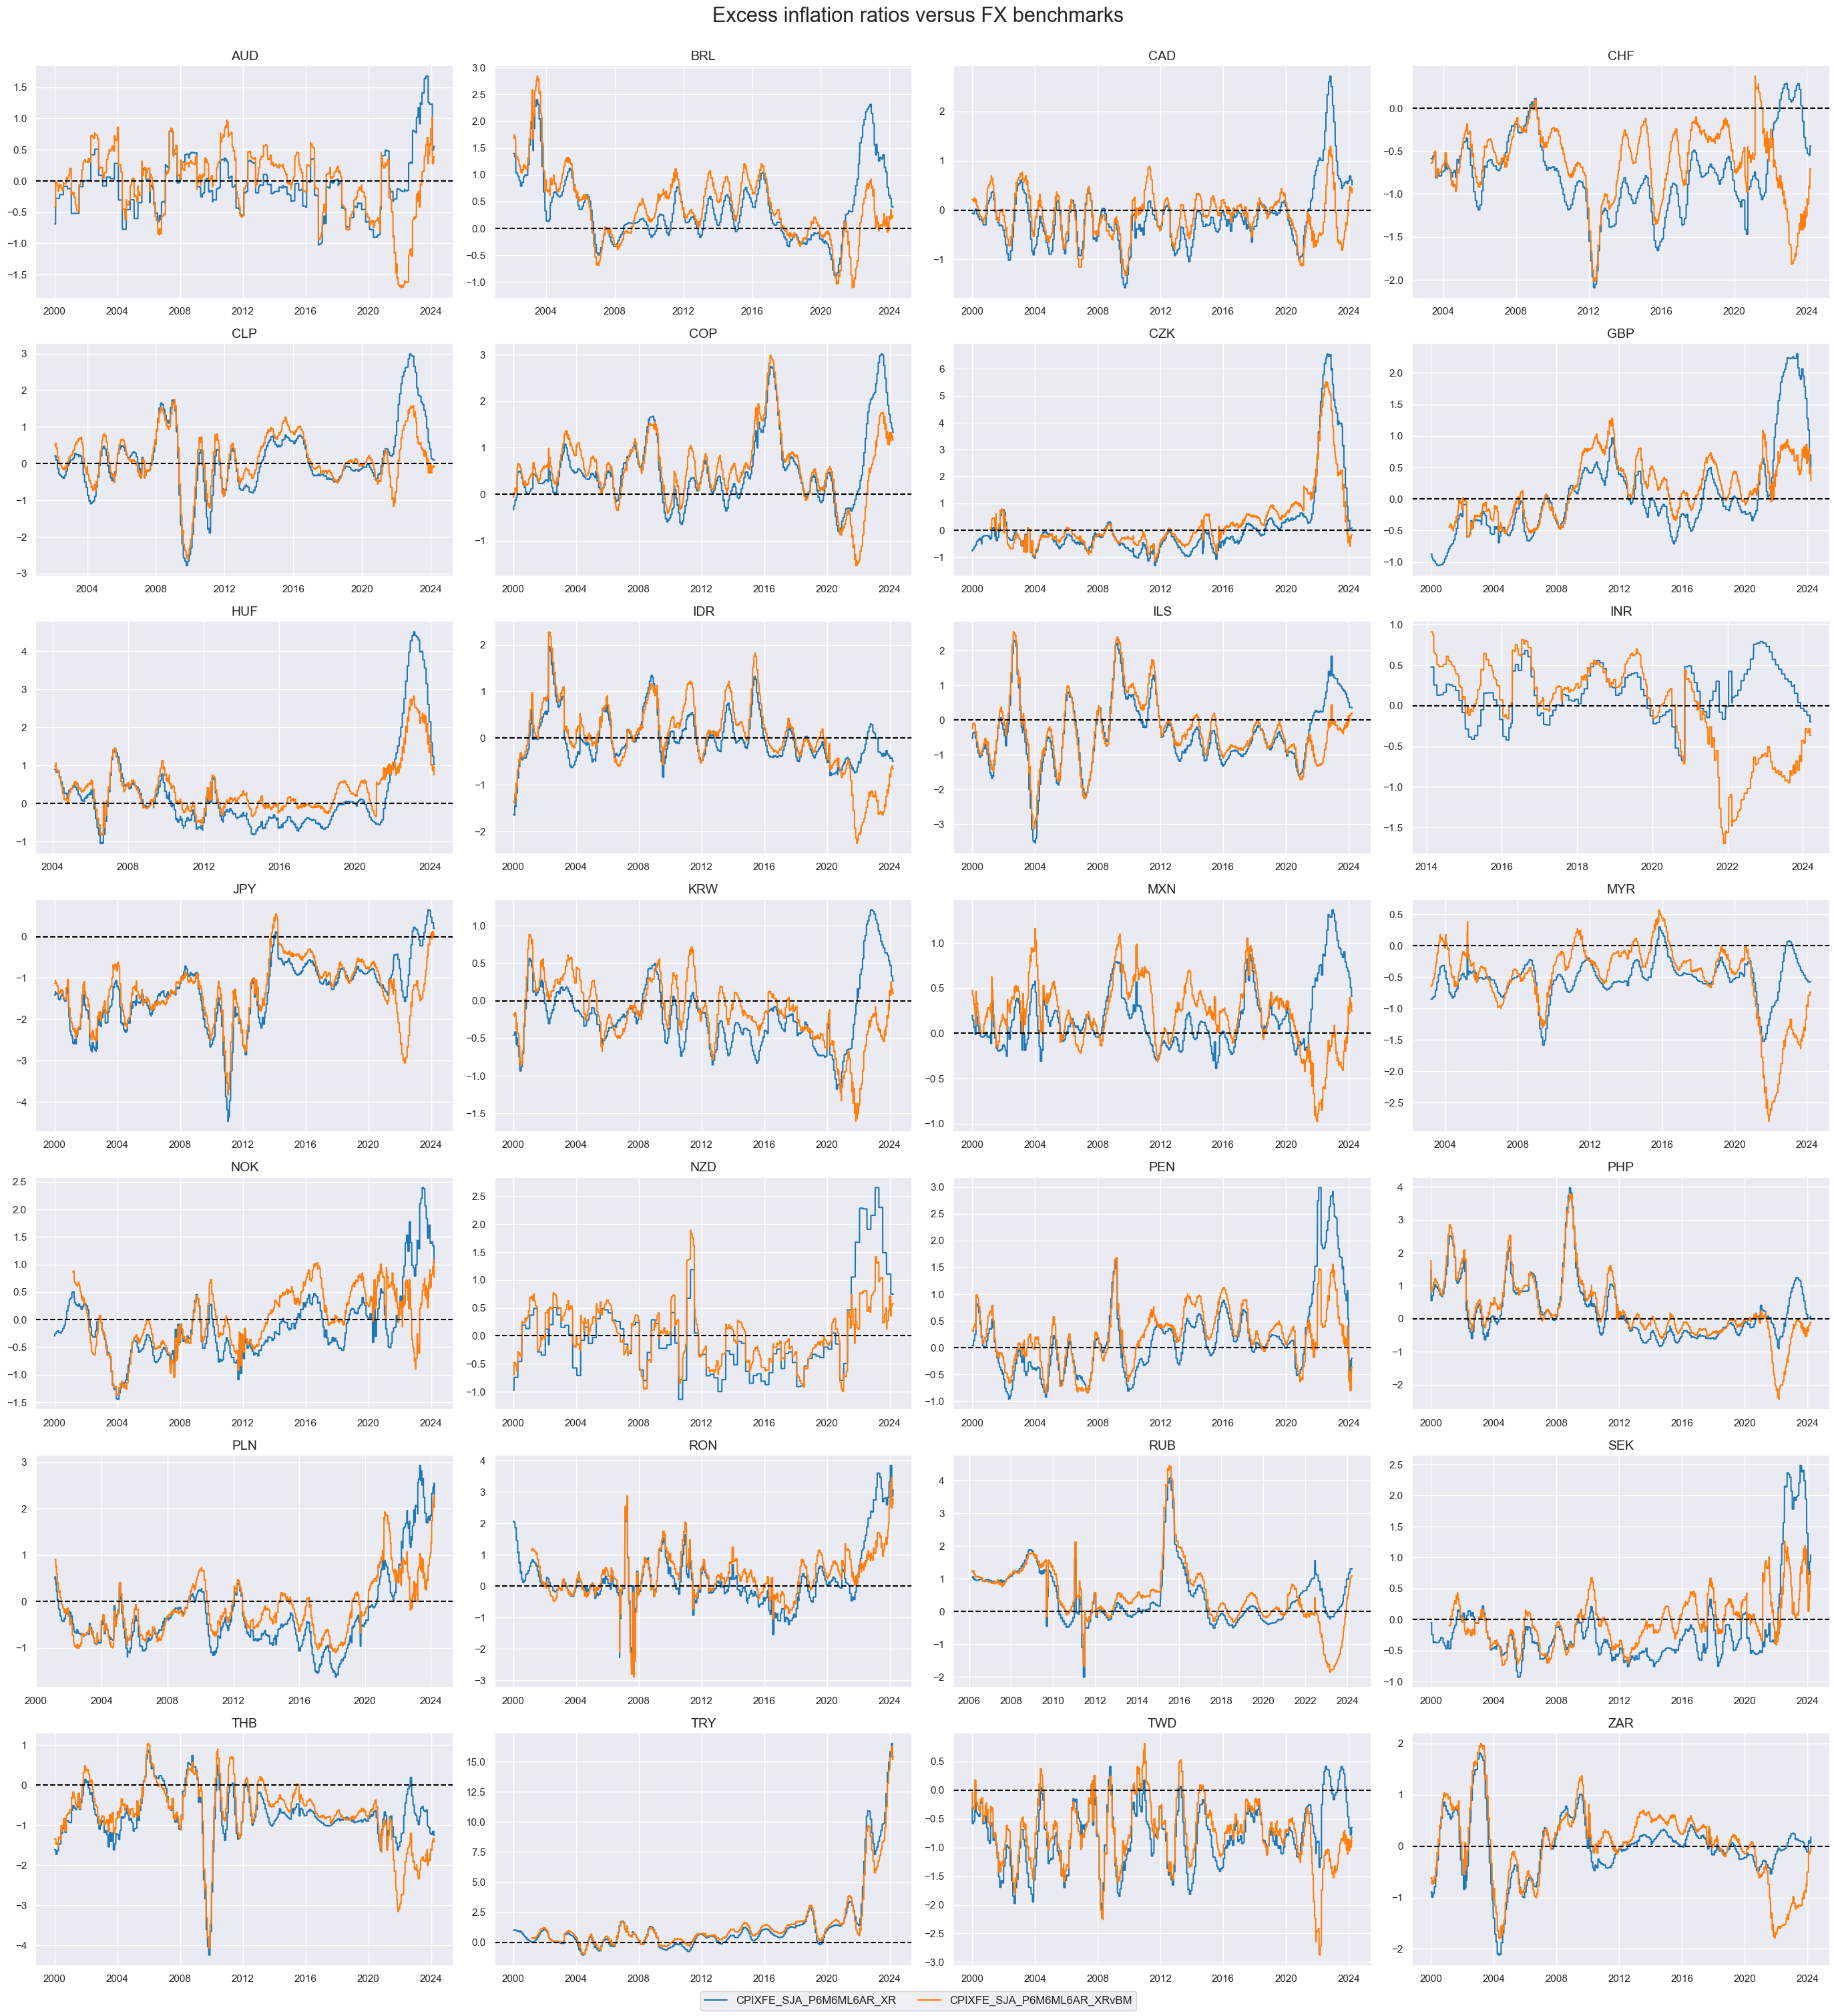

In [14]:
xcats_sel = ["CPIXFE_SJA_P6M6ML6AR_XR", "CPIXFE_SJA_P6M6ML6AR_XRvBM"]
sdate = "2000-01-01"


msp.view_timelines(
    dfx,
    xcats=xcats_sel,
    cids=cids_fx,
    ncol=4,
    cumsum=False,
    start=sdate,
    same_y=False,
    size=(12, 12),
    all_xticks=True,
    title_fontsize=22,
    title="Excess inflation ratios versus FX benchmarks",
    xcat_labels=None,
)

#### Relative excess inflation versus benchmarks and FX basket

In this step we use the relative excess inflation indicators (versus Benchmark) with postfix `_vBM` and compare them with the basket of "smaller" developed markets currencies EXCLUDING EUR and USD: ['JPY', 'AUD', 'CAD', 'CHF', 'GBP', 'NOK', 'NZD', 'SEK']. This basket excludes EUR and USD since those relative values are already part of the calculation for `_vBM` indicators.

In [15]:
xcatx = [inf + "_" + xr for inf in infs for xr in ["XRvBM", "EXRvBM"]]

dfa = msp.make_relative_value(
    dfx, xcats=xcatx, cids=cids_dmfx, postfix="vDM", blacklist=fxblack
)
dfx = msm.update_df(dfx, dfa)

To visualize the resulting Relative excess inflation versus benchmarks and FX basket indicators we again use the customized function [`view_timelines()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-time-series-with-view-timelines) from the `macrosynergy` package. We choose for visualization two inflation indicators `CPIXFE_SJA_P6M6ML6AR_XRvBM`, `CPIXFE_SJA_P6M6ML6AR_XRvBMvDM` which we later use for generating trading signals

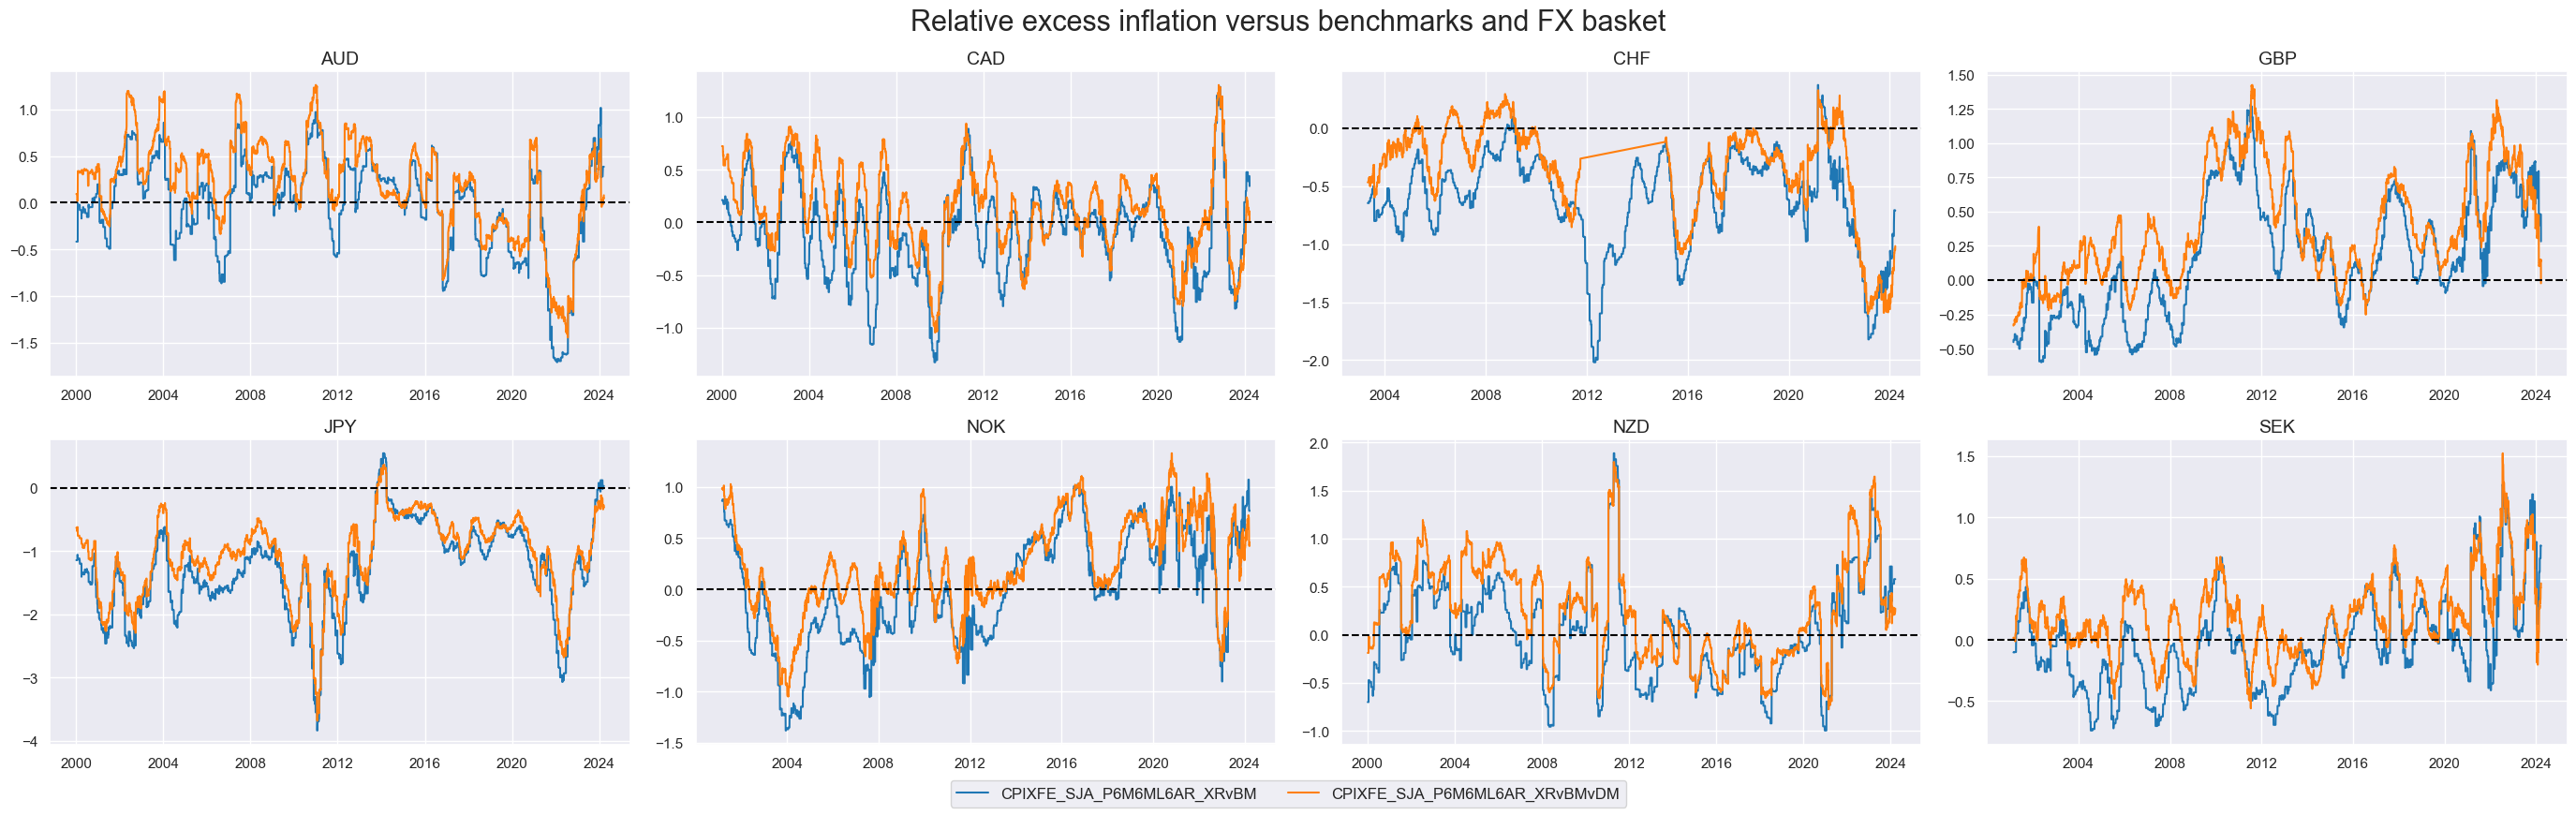

In [16]:
xcats_sel = ["CPIXFE_SJA_P6M6ML6AR_XRvBM", "CPIXFE_SJA_P6M6ML6AR_XRvBMvDM"]

sdate = "2000-01-01"


msp.view_timelines(
    dfx,
    xcats=xcats_sel,
    cids=cids_dmfx,
    ncol=4,
    cumsum=False,
    start=sdate,
    same_y=False,
    size=(12, 12),
    all_xticks=True,
    title_fontsize=22,
    title="Relative excess inflation versus benchmarks and FX basket",
    xcat_labels=None,
)

### Targets

#### Relative duration returns

We define relative duration returns as difference between [`DU02YXR_VT10`, Vol-targeted duration return](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Duration%20returns.php) and basket of developed markets duration returns. The basket consists of ['EUR', 'JPY', 'USD', 'AUD', 'CAD', 'CHF', 'GBP', 'NOK', 'NZD', 'SEK']

In [17]:
dfa = msp.make_relative_value(
    dfx, xcats=["DU02YXR_VT10"], cids=cids_dmdu, postfix="vDM"
)
dfx = msm.update_df(dfx, dfa)

Here is a quick visual comparison of simple  [`DU02YXR_VT10`, Vol-targeted duration return](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Duration%20returns.php) and relative to basket of developed markets returns, `DU02YXR_VT10vDM`. Please note, that we use option `cumsum` as part of `view_timelines()` function. This option is often used for returns.

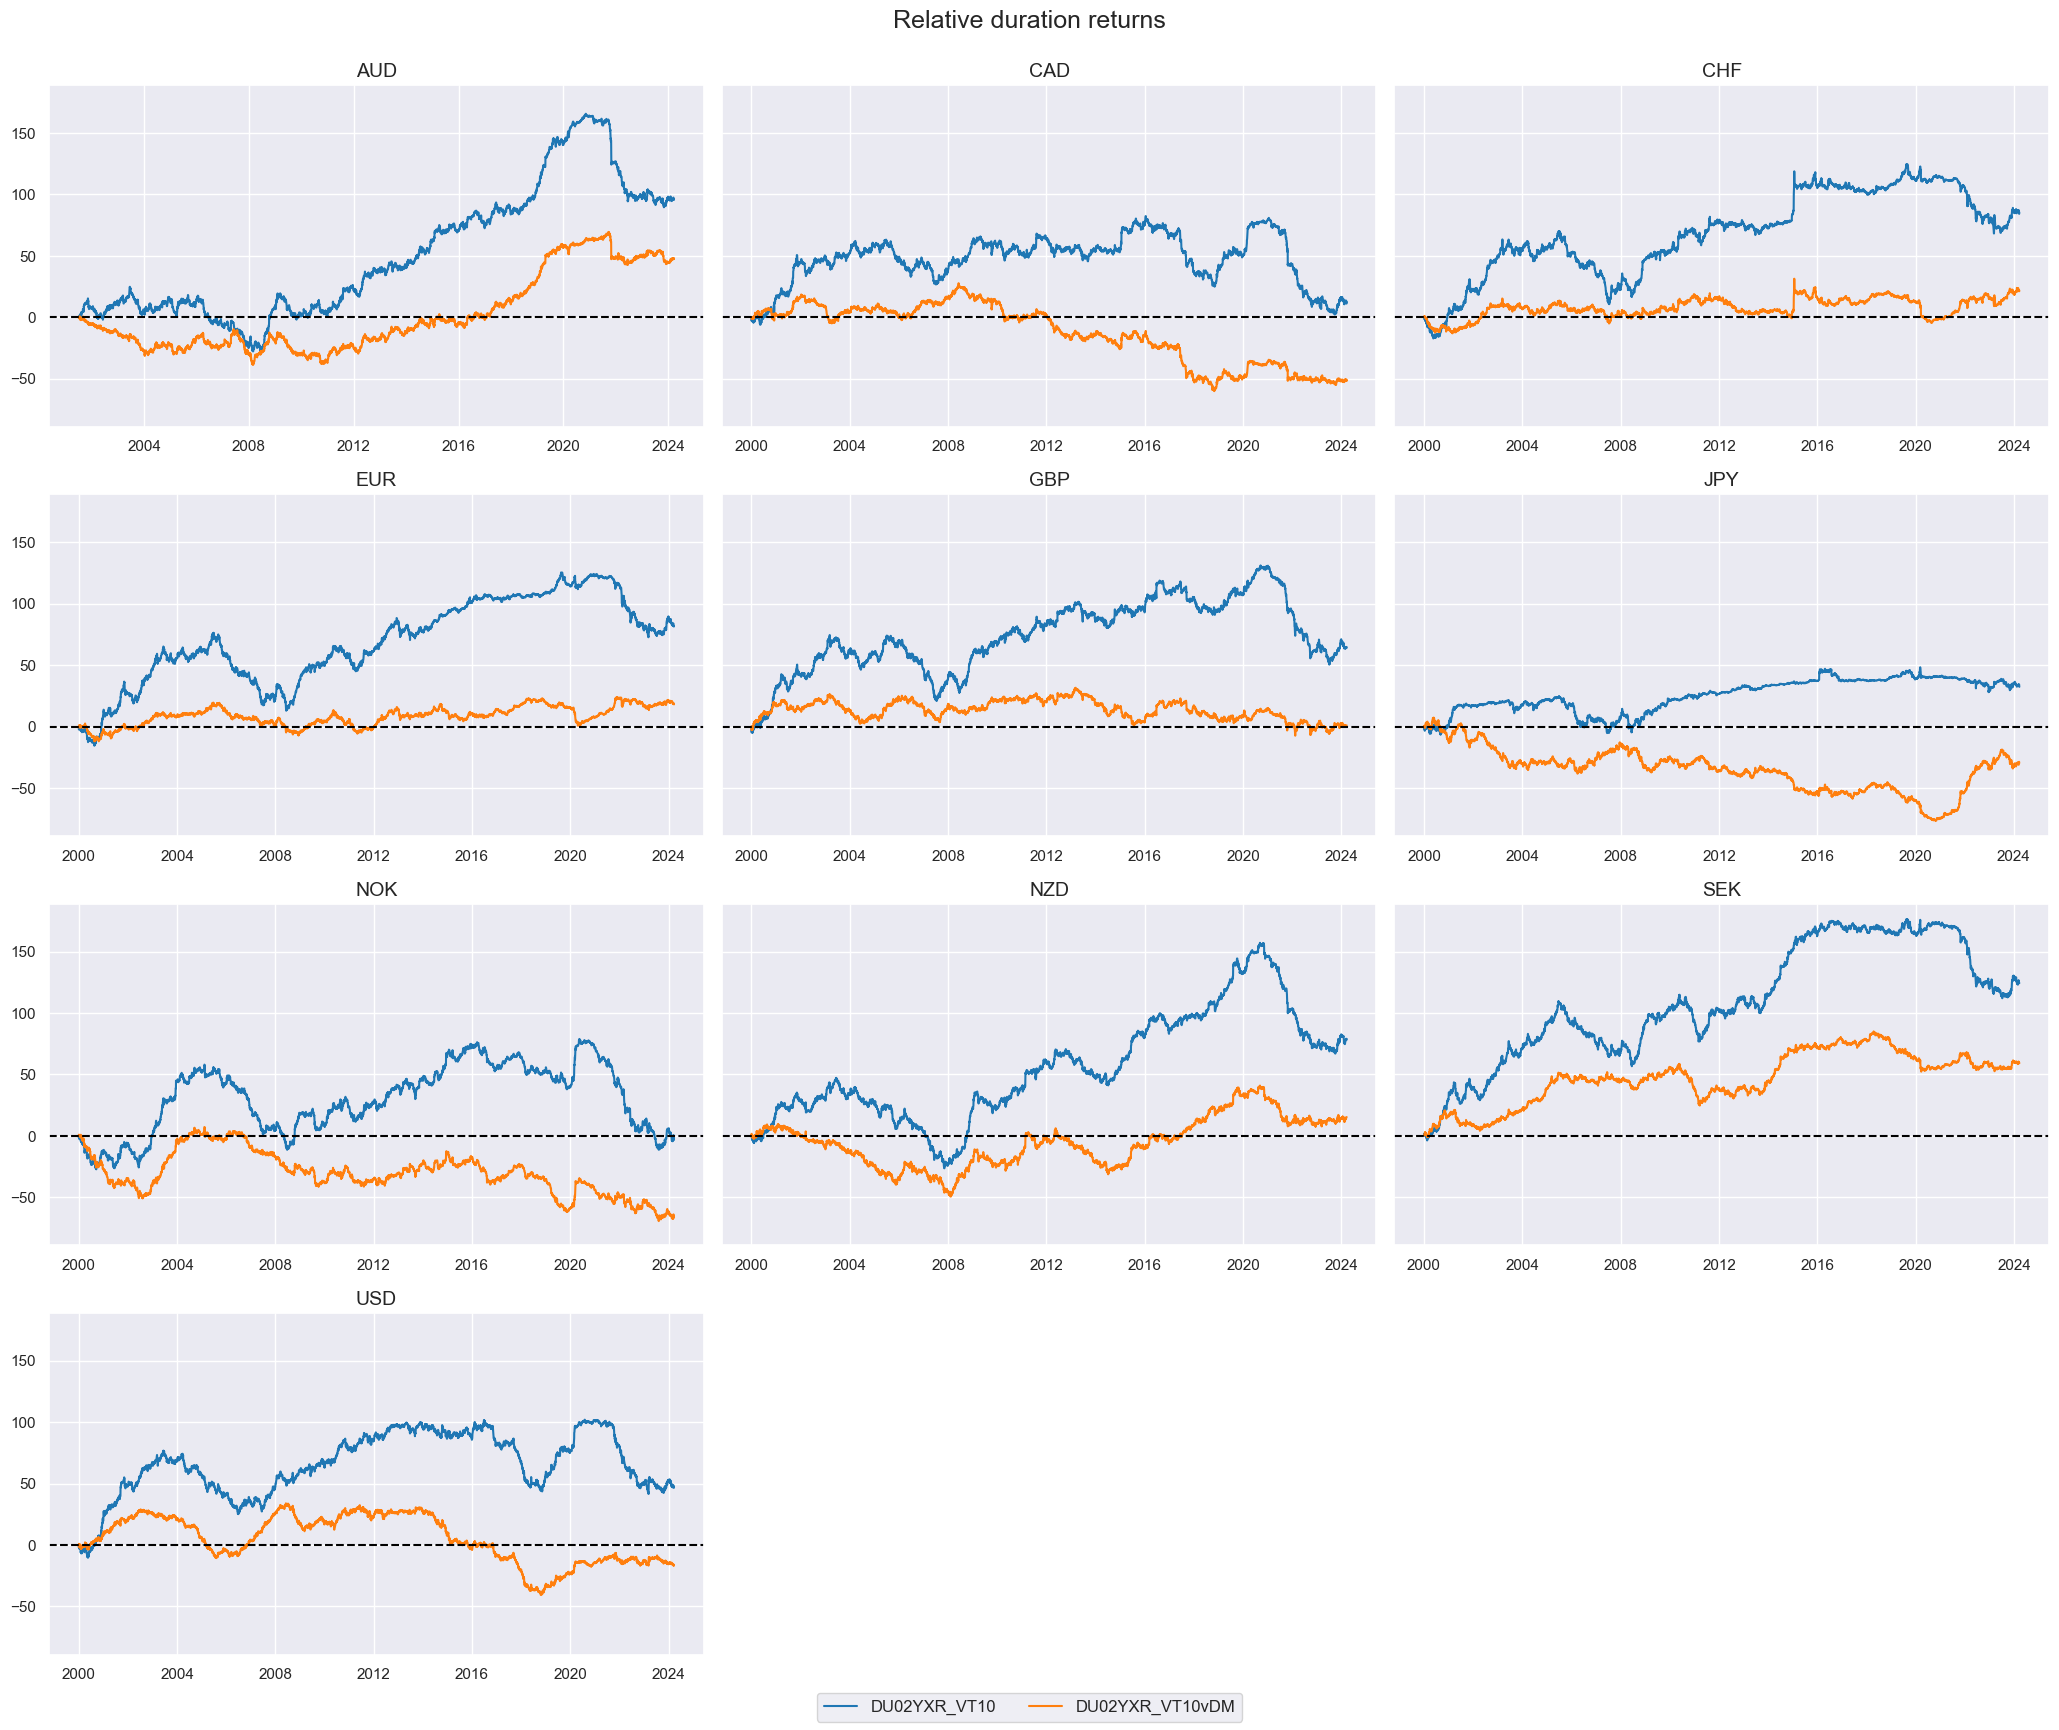

In [18]:
xcatx = ["DU02YXR_VT10", "DU02YXR_VT10vDM"]
sdate = "2000-01-01"
cidx = cids_dmdu


msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cids_dmdu,
    ncol=3,
    cumsum=True,
    start=sdate,
    same_y=True,
    size=(12, 12),
    all_xticks=True,
    title_fontsize=18,
    title="Relative duration returns",
    xcat_labels=None,
)

#### Relative FX returns

Similar relative calculation as above, but with FX volatility targeted return [`FXXR_VT10`](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/FX%20forward%20returns.php#vol-targeted-fx-forward-return) calculated against the basket of developed markets currencies excluding EUR and USD ['JPY', 'AUD', 'CAD', 'CHF', 'GBP', 'NOK', 'NZD', 'SEK']. The new indicators get postfix `_vDM`

In [19]:
dfa = msp.make_relative_value(dfx, xcats=["FXXR_VT10"], cids=cids_dmfx, postfix="vDM")
dfx = msm.update_df(dfx, dfa)

Here is a quick visual comparison of simple  [`FXXR_VT10`](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/FX%20forward%20returns.php#vol-targeted-fx-forward-return) and relative to basket of developed markets returns return `FXXR_VT10vDM`. Please note, that we use here again the option `cumsum` as part of `view_timelines()` function. This option is often used for returns.

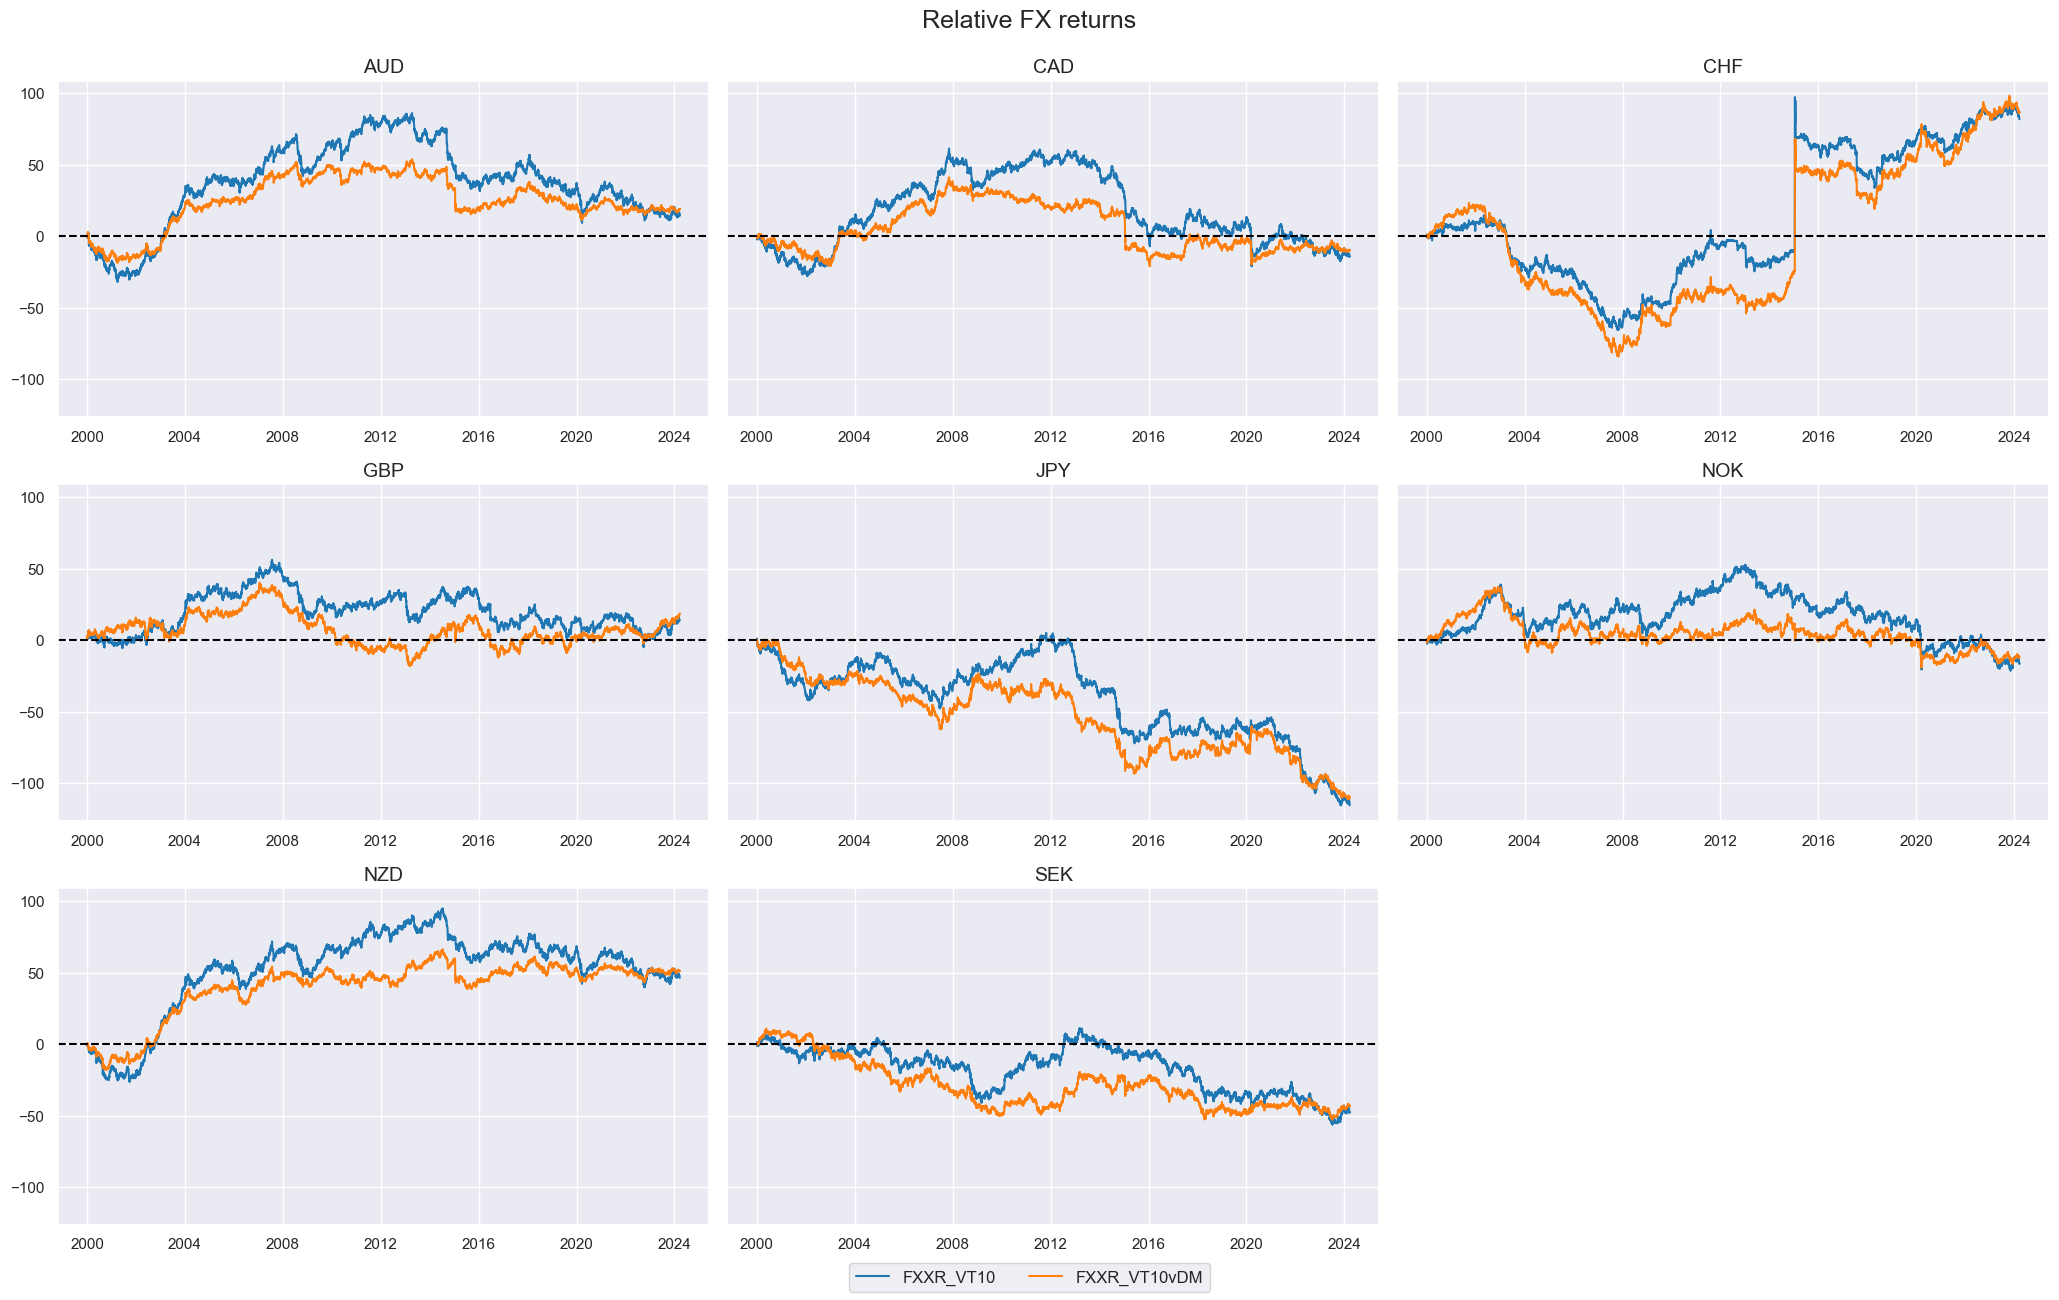

In [20]:
xcatx = ["FXXR_VT10", "FXXR_VT10vDM"]
sdate = "2000-01-01"
cidx = cids_dmdu


msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cids_dmfx,
    ncol=3,
    cumsum=True,
    start=sdate,
    same_y=True,
    size=(12, 12),
    all_xticks=True,
    title_fontsize=18,
    title="Relative FX returns",
    xcat_labels=None,
)

## Value checks

In this part of the analysis, the notebook calculates the naive PnLs (Profit and Loss) for Fixed Income, Equity, and FX strategies using the previously discussed excess inflation measures. The PnLs are calculated based on simple trading strategies that utilize the excess inflation measures as signals (no regression). The strategies involve going long (buying) or short (selling) on Fixed Income, Equity, or FX positions based purely on the direction of the excess inflation signals.

To evaluate the performance of these strategies, the notebook computes various metrics and ratios, including:

- Correlation: Measures the relationship between the excess inflation-based strategy returns and the actual returns of Fixed Income, Equity, and FX markets. Positive correlations indicate that the strategy moves in the same direction as the market, while negative correlations indicate an opposite movement.

- Accuracy Metrics: These metrics assess the accuracy of the excess inflation-based strategies in predicting market movements. Common accuracy metrics include accuracy rate, balanced accuracy, precision etc.

- Performance Ratios: Various performance ratios, such as Sharpe ratio, Sortino ratio, Max draws etc.

The notebook compares the performance of these simple excess inflation-based strategies with the long-only performance of the respective asset classes. 

It's important to note that the analysis deliberately disregards transaction costs and risk management considerations. This is done to provide a more straightforward comparison of the strategies' raw performance without the additional complexity introduced by transaction costs and risk management, which can vary based on trading size, institutional rules, and regulations.

### Fixed income returns

We estimate the predictive power of excess inflation for two-year interest rate swap returns. The two-year tenor in the rates market should be most closely aligned with the monetary policy outlook. In particular, we investigate the relationship between the excess core inflation trend as available at the end of the month and the swap receiver return performance during the following month. Receiver positions have been calibrated to a 10% predicted volatility target in order to make return variation comparable across countries. We would expect a negative relation, i.e. high inflation giving rise to low or negative returns.



#### Directional excess

For fixed income strategy we choose `CPIC_SJA_P6M6ML6AR_XR` as the main signal. The signal is the excess inflation rate, which is the difference between the seasonally and jump-adjusted core consumer price trends, % 6m/6m ar (`CPIC_SJA_P6M6ML6AR`) and the official inflation target (`INFTARGETO_NSA`). As target we choose [`DU02YXR_VT10`, Vol-targeted duration return](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Duration%20returns.php). The strategy is calculated for developed countries ['EUR', 'JPY', 'USD', 'AUD', 'CAD', 'CHF', 'GBP', 'NOK', 'NZD', 'SEK']. We also use alternative excess and effective excess inflation rates as signals based on different inflation indicators.

In [21]:
ios = [
    inf + "_" + xr for inf in infs for xr in ["XR", "EXR"]
]  # all inflation overshootings, both XR and EXR
ms = "CPIC_SJA_P6M6ML6AR_XR"  # main signal
oths = list(set(ios) - set([ms]))  # other signals

dict_dudi = {
    "sig": ms,
    "rivs": oths,
    "targ": "DU02YXR_VT10",
    "cidx": cids_dmdu,
    "black": None,
    "srr": None,
    "pnls": None,
}

Useful function `CategoryRelations()` we visualize the relationship between the main signal and target. The function allows aggregation (last value for signal and sum for target), we choose monthly reestimation frequency and lag of 1 month (i.e. we estimate the relationship between the signal and subsequent target and thus allows analyzing signal's predictive power). 

Indeed, the empirical evidence clearly confirms the negative correlation between excess inflation at the end of a month and next month’s returns for the overall panel. Moreover, to gauge the significance of the relationship we use the [Macrosynergy panel test](https://research.macrosynergy.com/testing-macro-trading-factors/). Simply looking at the significance of the correlation for the pooled data set (which is near 100%) can be misleading. This is because features and targets across currency areas are not independent and subject to common global market factors. Simply stacking data means “pseudo-replication” and surely overstates significance. Instead, the Macrosynergy panel tests check significance through panel regression models with period-specific random effects, adjusting the predictive regression for common (global) influences. Put simply, the method automatically accounts for the similarity of experiences across markets when assessing the significance.

Yet even accounting for communal global effects, the Macrosynergy panel test suggests that the probability of negative correlation based on the sample is over 99%.

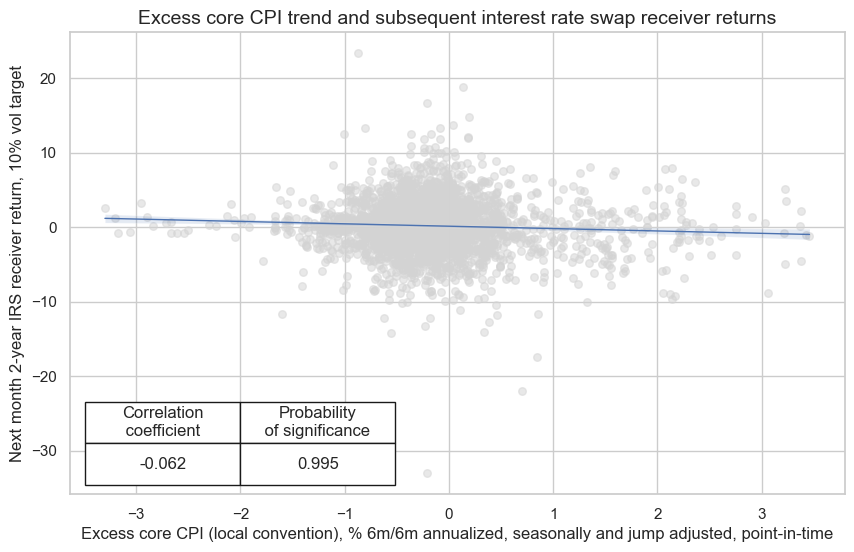

In [22]:
dix = dict_dudi

sig = dix["sig"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]

crx = msp.CategoryRelations(
    dfx,
    xcats=[sig, targ],
    cids=cidx,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    start="2000-01-01",
    blacklist=blax,
    xcat_trims=[None, None],
)
crx.reg_scatter(
    labels=False,
    coef_box="lower left",
    # separator=2011,
    xlab="Excess core CPI (local convention), % 6m/6m annualized, seasonally and jump adjusted, point-in-time",
    ylab="Next month 2-year IRS receiver return, 10% vol target",
    title="Excess core CPI trend and subsequent interest rate swap receiver returns",
    size=(10, 6),
    prob_est="map",
)

Similar calculation can be done by cross-section to check if all markets have similar correlation strengh. The negative relation has prevailed for 9 out of 10 countries since 2000. The only exception has been Japan, which is plausible since Japanese policy rates had been trapped near the zero lower bounds for most of the sample period and persistent deflation constrained the central bank’s influence on financial conditions. Switzerland faced similar issues. This suggests that a more advanced trading signal should also consider swap yield levels.

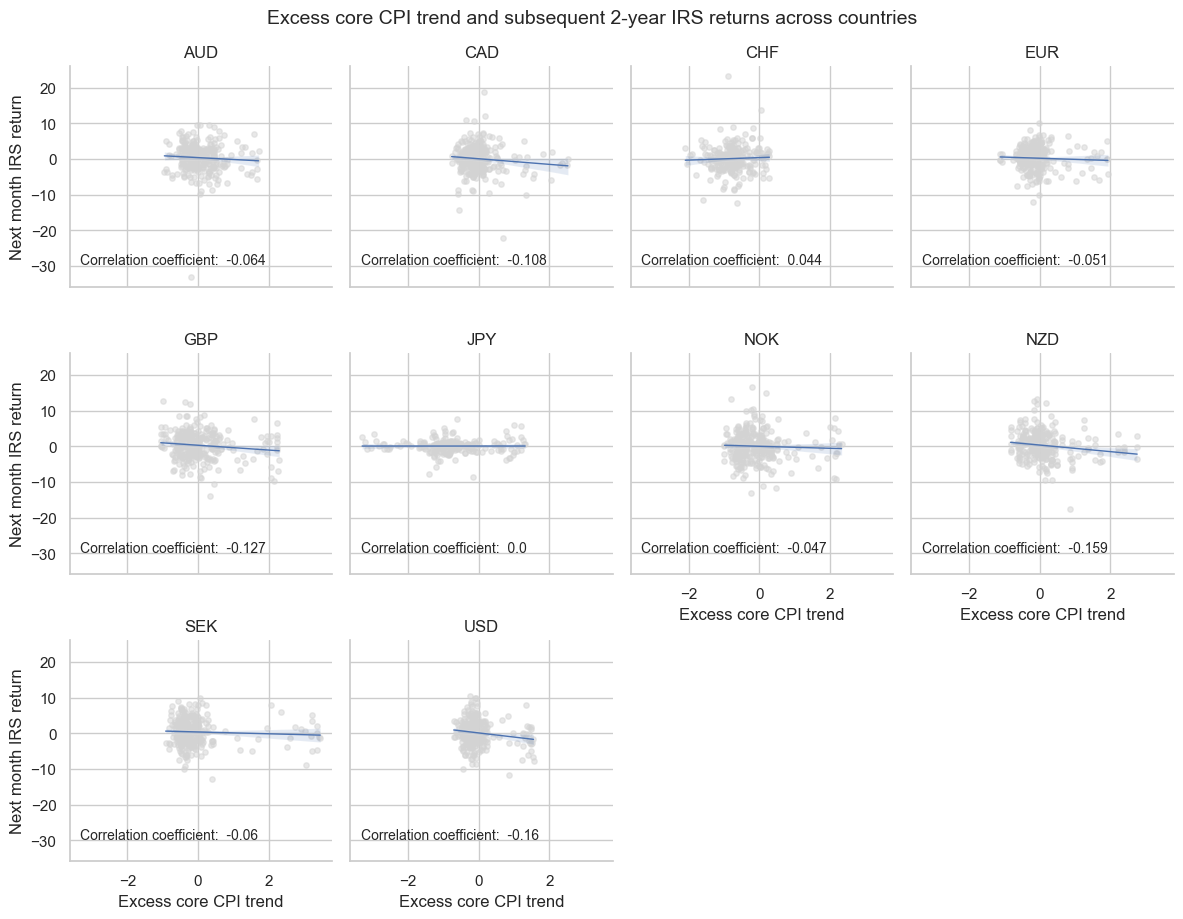

In [23]:
dix = dict_dudi

sig = dix["sig"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]

crx = msp.CategoryRelations(
    dfx,
    xcats=[sig, targ],
    cids=cidx,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    start="2000-01-01",
    blacklist=blax,
    xcat_trims=[None, None],
)
crx.reg_scatter(
    labels=False,
    coef_box="lower left",
    separator="cids",
    xlab="Excess core CPI trend",
    ylab="Next month IRS return",
    title="Excess core CPI trend and subsequent 2-year IRS returns across countries",
    title_adj=1.02,
    size=(10, 6),
    prob_est="map",
)

##### Accuracy and correlation check

We use [`SignalReturnRelations`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#signalreturnrelations) class from the `macrosynergy` package. Signal module is specifically designed to analyze, visualize and compare the relationships between panels of trading signals and panels of subsequent returns. It is very important to note, that there is no regression analysis involved, hence the sign of the feature is critical for accuracy statistics. 

We continue analysing the relationship between the excess inflation rate, which is the difference between the seasonally and jump-adjusted core consumer price trends, % 6m/6m ar (`CPIC_SJA_P6M6ML6AR`) and the official inflation target (`INFTARGETO_NSA`) as the main signal and [`DU02YXR_VT10`, 2-year IRS return](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Duration%20returns.php) as the target.

In [24]:
dix = dict_dudi

sig = dix["sig"]
rivs = dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]

srr = mss.SignalReturnRelations(
    dfx,
    cids=cidx,
    sigs=[sig] + rivs,
    sig_neg=[True] * (len(rivs) + 1),
    rets=targ,
    freqs="M",
    start="2000-01-01",
    blacklist=blax,
)

dix["srr"] = srr

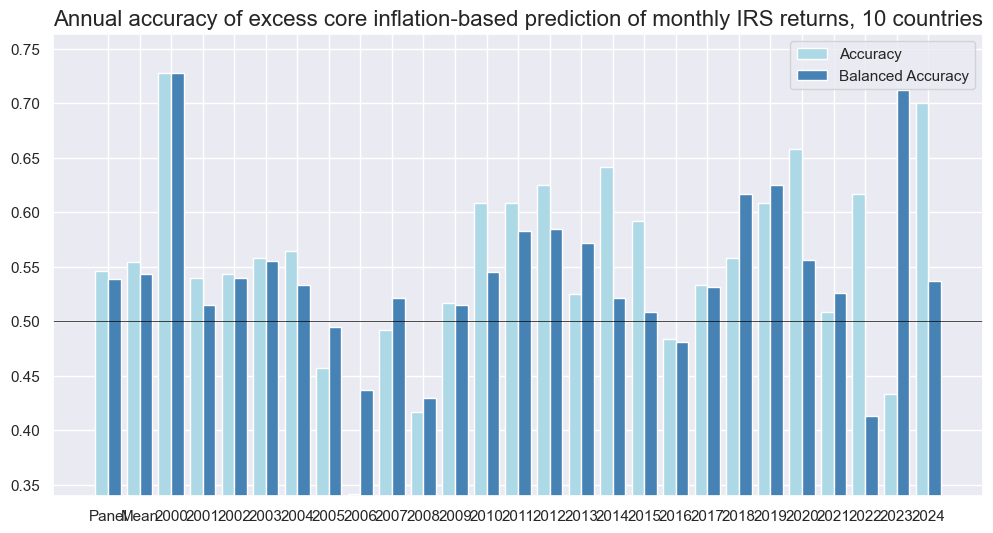

In [25]:
dix = dict_dudi
srrx = dix["srr"]
srrx.accuracy_bars(
    type="years",
    title="Annual accuracy of excess core inflation-based prediction of monthly IRS returns, 10 countries",
    size=(12, 6),
)

##### Naive PnL

`NaivePnl()` class is designed to provide a quick and simple overview of a stylized PnL profile of a set of trading signals. The class carries the label naive because its methods do not take into account transaction costs or position limitations, such as risk management considerations. Just repeating what we stated above, this is deliberate because costs and limitations are specific to trading size, institutional rules, and regulations.

In [26]:
dix = dict_dudi

sigx = [dix["sig"]] + dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]

naive_pnl = msn.NaivePnL(
    dfx,
    ret=targ,
    sigs=sigx,
    cids=cidx,
    start="2000-01-01",
    blacklist=blax,
    #   bms=["USD_EQXR_NSA"],
)

for sig in sigx:
    naive_pnl.make_pnl(
        sig,
        sig_neg=True,
        sig_op="zn_score_pan",
        thresh=2,
        rebal_freq="monthly",
        vol_scale=10,
        rebal_slip=1,
        pnl_name=sig + "_PZN",
    )

naive_pnl.make_long_pnl(vol_scale=10, label="Long only")
dix["pnls"] = naive_pnl

The `plot_pnls()` method of the NaivePnl() class is used to plot a line chart of cumulative PnL. 

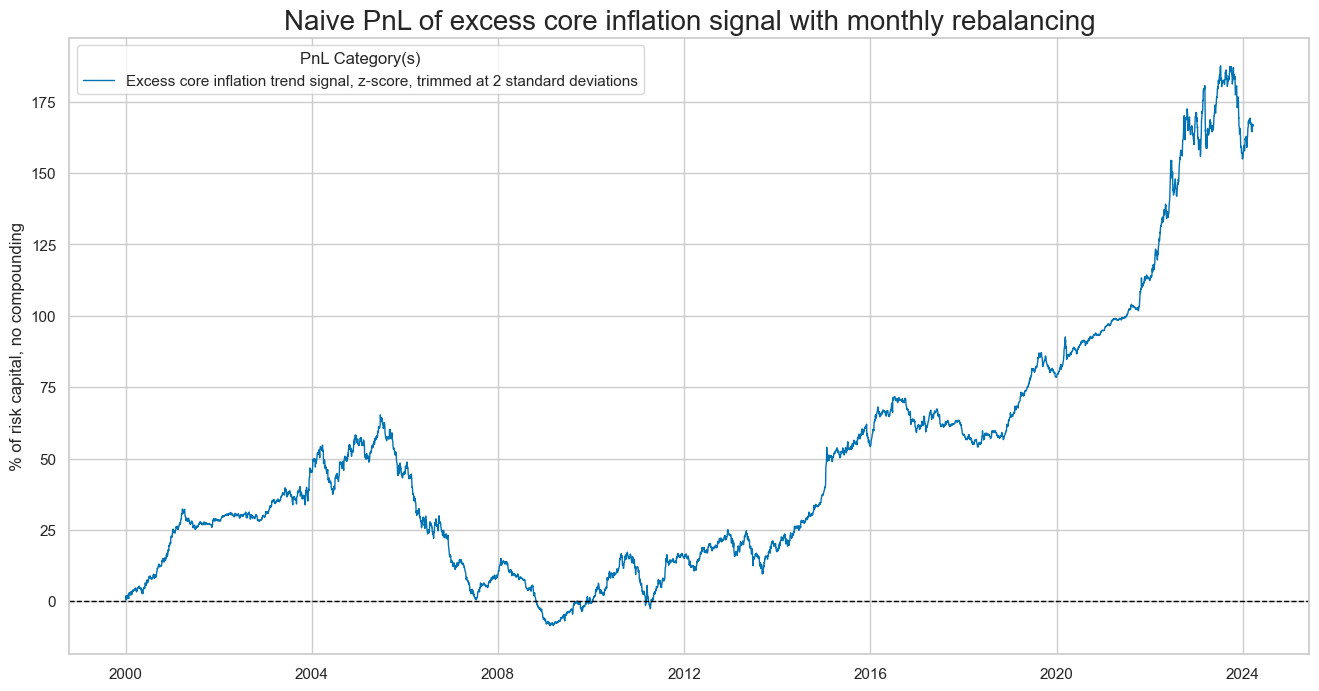

In [27]:
dix = dict_dudi

sigx = [
    "CPIC_SJA_P6M6ML6AR_XR",
]
naive_pnl = dix["pnls"]
pnls = [sig + "_PZN" for sig in sigx]

dict_labels={"CPIC_SJA_P6M6ML6AR_XR_PZN": "Excess core inflation trend signal, z-score, trimmed at 2 standard deviations"}

naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start="2000-01-01",
    title="Naive PnL of excess core inflation signal with monthly rebalancing",
    xcat_labels=dict_labels,
    figsize=(16, 8),
)

#### Relative excess

Similar analysis is performed for relative values: For relative fixed income strategy, we choose `CPIC_SJA_P6M6ML6AR_XRvDMDU` (relative excess inflation indicators versus duration basket) as the main signal. As target, we choose `DU02YXR_VT10vDM`, also calculated above under "Relative duration returns". The strategy is calculated for developed countries ['EUR', 'JPY', 'USD', 'AUD', 'CAD', 'CHF', 'GBP', 'NOK', 'NZD', 'SEK']. We also use alternative relative excess and effective excess inflation rates as signals based on different inflation indicators for comparison later.

In [28]:
ios = [
    inf + "_" + xr for inf in infs for xr in ["XRvDMDU", "EXRvDMDU"]
]  # all inflation overshootings
ms = "CPIC_SJA_P6M6ML6AR_XRvDMDU"  # main signal
oths = list(set(ios) - set([ms]))  # other signals

dict_durv = {
    "sig": ms,
    "rivs": oths,
    "targ": "DU02YXR_VT10vDM",
    "cidx": cids_dmdu,
    "black": None,
    "srr": None,
    "pnls": None,
}

As before we use `CategoryRelations()` to visualize the relationship between the main signal and target. The function allows aggregation (last value for signal and sum for target), we choose monthly reestimation frequency and lag of 1 month (i.e. we estimate the relationship between the signal and subsequent target and thus allows analyzing signal's predictive power.)

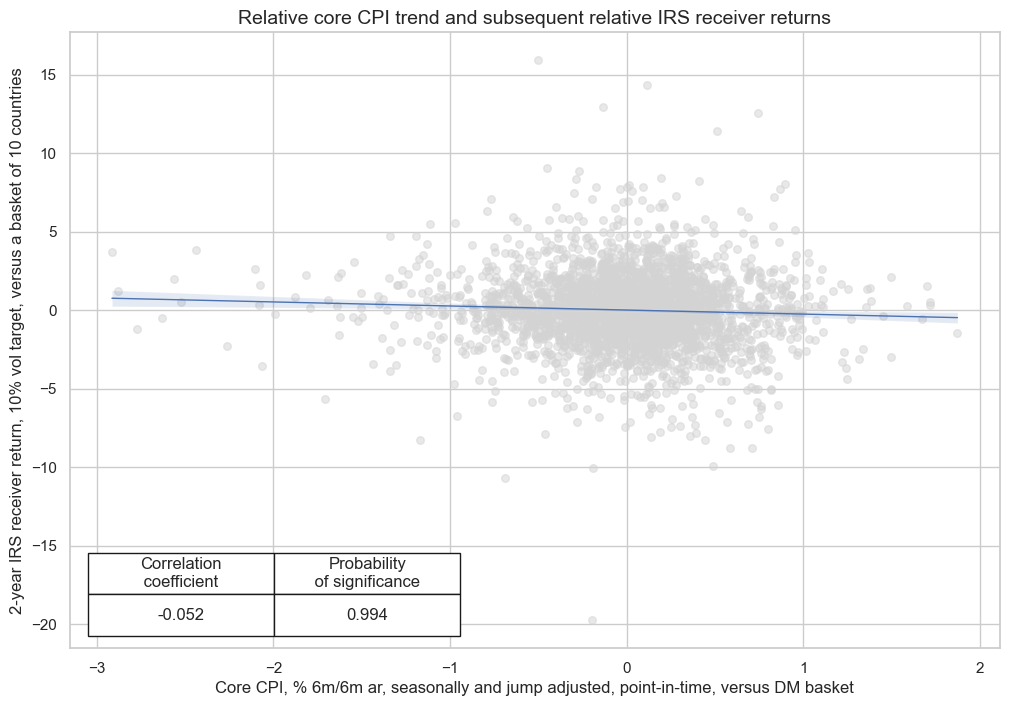

In [29]:
dix = dict_durv

sig = dix["sig"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]

crx = msp.CategoryRelations(
    dfx,
    xcats=[sig, targ],
    cids=cidx,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    start="2000-01-01",
    blacklist=blax,
    xcat_trims=[None, None],
)
crx.reg_scatter(
    labels=False,
    coef_box="lower left",
    # separator=2011,
    xlab="Core CPI, % 6m/6m ar, seasonally and jump adjusted, point-in-time, versus DM basket",
    ylab="2-year IRS receiver return, 10% vol target, versus a basket of 10 countries",
    title="Relative core CPI trend and subsequent relative IRS receiver returns",
    size=(12, 8),
    prob_est="map",
)

##### Accuracy and correlation check

Again we use [`SignalReturnRelations`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#signalreturnrelations) class from the `macrosynergy` package. It is very important to note, that there is no regression analysis involved, hence the sign of the feature is critical for accuracy statistics. 

We continue analysing the relationship between the `CPIC_SJA_P6M6ML6AR_XRvDMDU` (relative excess inflation indicators versus duration basket) as the main signal. As target we choose relative to basket of developed markets returns, `DU02YXR_VT10vDM`

In [30]:
dix = dict_durv

sig = dix["sig"]
rivs = dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]

srr = mss.SignalReturnRelations(
    dfx,
    cids=cidx,
    sigs=[sig] + rivs,
    sig_neg=[True] * (len(rivs) + 1),
    rets=targ,
    freqs="M",
    start="2000-01-01",
    blacklist=blax,
)

dix["srr"] = srr

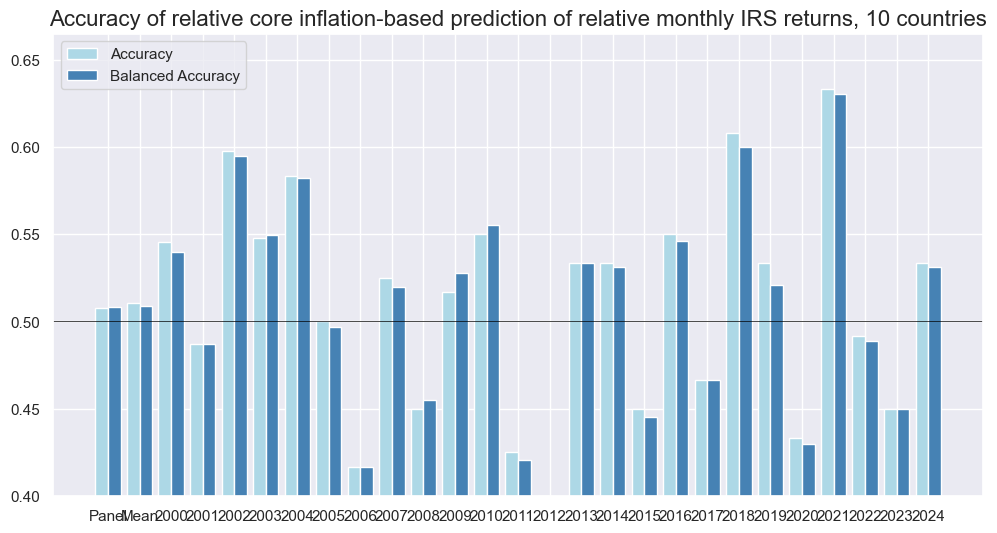

In [31]:
dix = dict_durv
srrx = dix["srr"]
srrx.accuracy_bars(
    type="years",
    title="Accuracy of relative core inflation-based prediction of relative monthly IRS returns, 10 countries",
    size=(12, 6),
)

##### Naive Pnl

With `NaivePnl()` class we calculate stylized PnL profile of a set of trading signals,

In [32]:
dix = dict_durv

sigx = [dix["sig"]] + dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]

naive_pnl = msn.NaivePnL(
    dfx,
    ret=targ,
    sigs=sigx,
    cids=cidx,
    start="2000-01-01",
    blacklist=blax,
    #   bms=["USD_EQXR_NSA", "USD_DU02YXR_NSA"],
)

for sig in sigx:
    naive_pnl.make_pnl(
        sig,
        sig_neg=True,
        sig_op="zn_score_pan",
        thresh=2,
        rebal_freq="monthly",
        vol_scale=10,
        rebal_slip=1,
        pnl_name=sig + "_PZN",
    )

dix["pnls"] = naive_pnl

The `plot_pnls()` method of the NaivePnl() class is used to plot a line chart of cumulative PnL. 

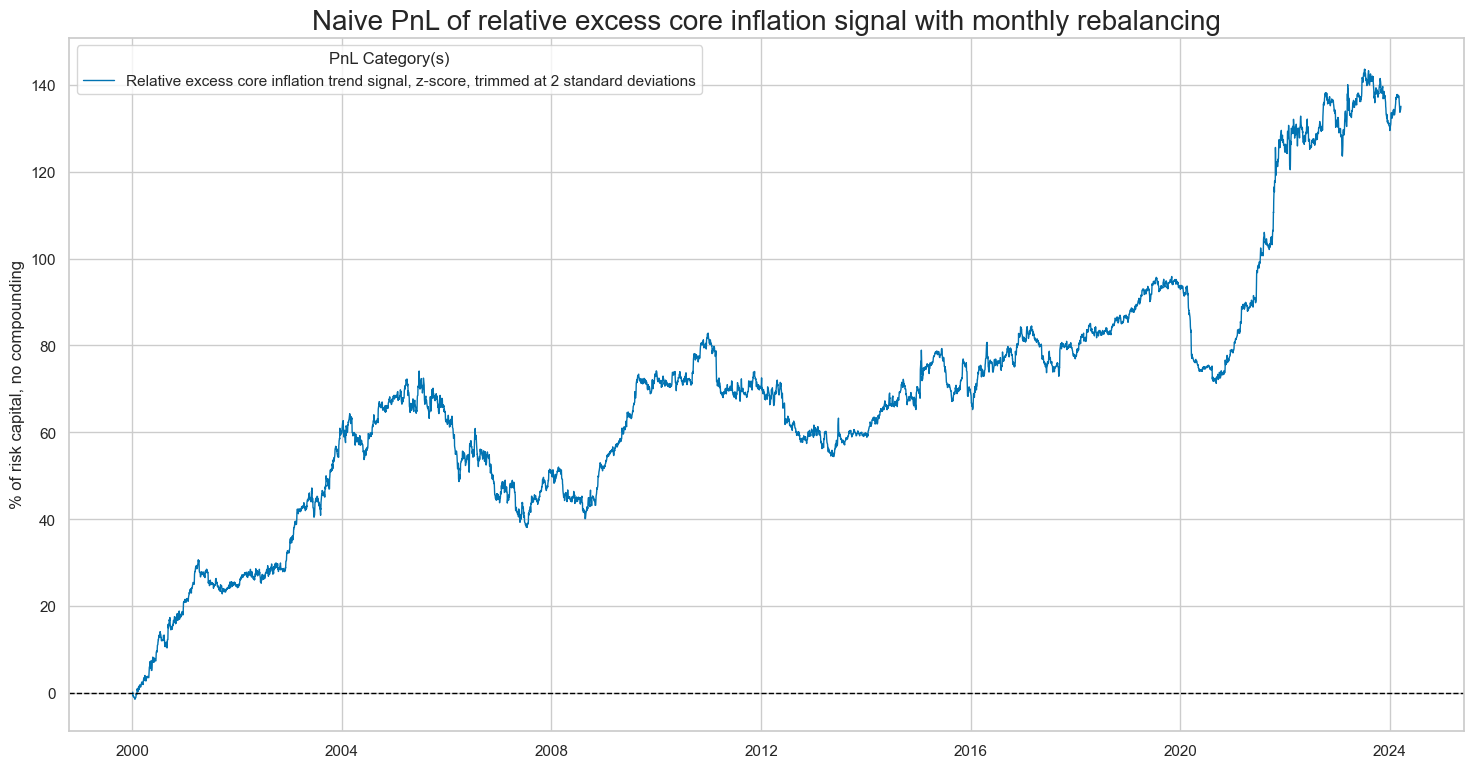

In [35]:
dix = dict_durv

sigx = [
    "CPIC_SJA_P6M6ML6AR_XRvDMDU",
]
naive_pnl = dix["pnls"]
pnls = [sig + "_PZN" for sig in sigx]

dict_labels={"CPIC_SJA_P6M6ML6AR_XRvDMDU_PZN": "Relative excess core inflation trend signal, z-score, trimmed at 2 standard deviations"}

naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start="2000-01-01",
    title="Naive PnL of relative excess core inflation signal with monthly rebalancing",
    xcat_labels=dict_labels,
    figsize=(18, 9),
)

### Equity returns

The hypothesis that we test here is that excess inflation predicts subsequent equity returns negatively. It follows from the assumption that if the risk of monetary policy is tilted towards tightening (and not fully priced) it translates into upside risks for the stochastic discount factor of the dividend discount model. This implies downside risk for equity returns. 

In [36]:
ios = [
    inf + "_" + xr for inf in infs for xr in ["XR", "EXR"]
]  # all inflation overshootings
ms = "CPIC_SJA_P6M6ML6AR_XR"  # main signal
oths = list(set(ios) - set([ms]))  # other signals

dict_eqdi = {
    "sig": ms,
    "rivs": oths,
    "targ": "EQXR_VT10",
    "cidx": cids_dmeq,
    "black": None,
    "srr": None,
    "pnls": None,
}

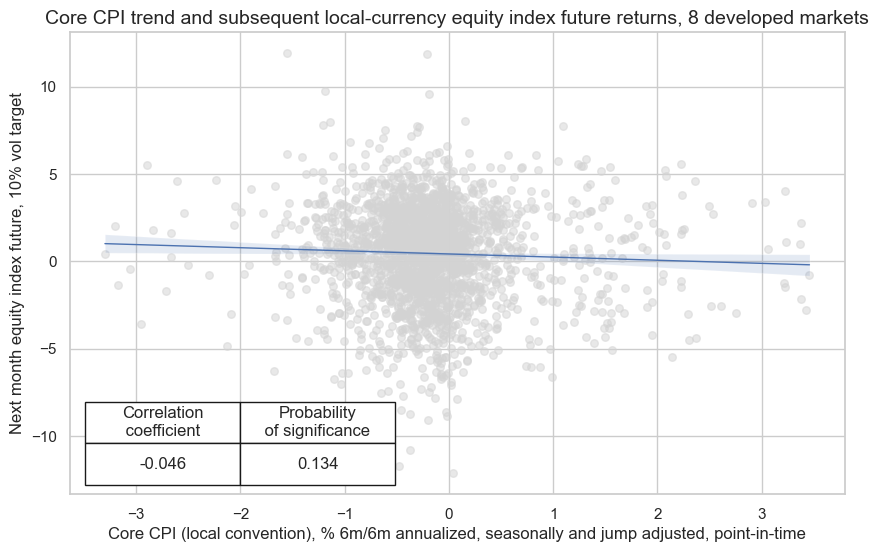

In [37]:
dix = dict_eqdi

sig = dix["sig"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]

crx = msp.CategoryRelations(
    dfx,
    xcats=[sig, targ],
    cids=cidx,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    start="2000-01-01",
    blacklist=blax,
    xcat_trims=[None, None],
)
crx.reg_scatter(
    labels=False,
    coef_box="lower left",
    # separator=2011,
    xlab="Core CPI (local convention), % 6m/6m annualized, seasonally and jump adjusted, point-in-time",
    ylab="Next month equity index future, 10% vol target",
    title="Core CPI trend and subsequent local-currency equity index future returns, 8 developed markets",
    size=(10, 6),
    prob_est="map",
)

Here we investigate the core CPI trend and subsequent local-currency equity index future returns only for the USD market and find almost 100% significance of the correlation.

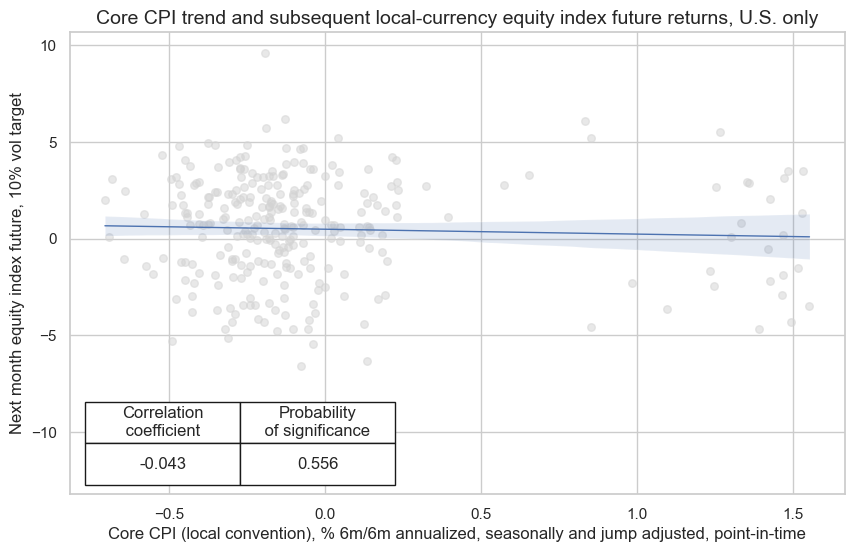

In [38]:
dix = dict_eqdi

sig = dix["sig"]
targ = dix["targ"]
cidx = ["USD"]  # US only
blax = dix["black"]

crx = msp.CategoryRelations(
    dfx,
    xcats=[sig, targ],
    cids=cidx,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    start="2000-01-01",
    blacklist=blax,
    xcat_trims=[None, None],
)
crx.reg_scatter(
    labels=False,
    coef_box="lower left",
    # separator=2011,
    xlab="Core CPI (local convention), % 6m/6m annualized, seasonally and jump adjusted, point-in-time",
    ylab="Next month equity index future, 10% vol target",
    title="Core CPI trend and subsequent local-currency equity index future returns, U.S. only",
    size=(10, 6),
    prob_est="map",
)

##### Accuracy and correlation check

In [39]:
dix = dict_eqdi

sig = dix["sig"]
rivs = dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]

srr = mss.SignalReturnRelations(
    dfx,
    cids=cidx,
    sigs=[sig] + rivs,
    sig_neg=[True] * (len(rivs) + 1),
    rets=targ,
    freqs="M",
    start="2000-01-01",
    blacklist=blax,
)

dix["srr"] = srr

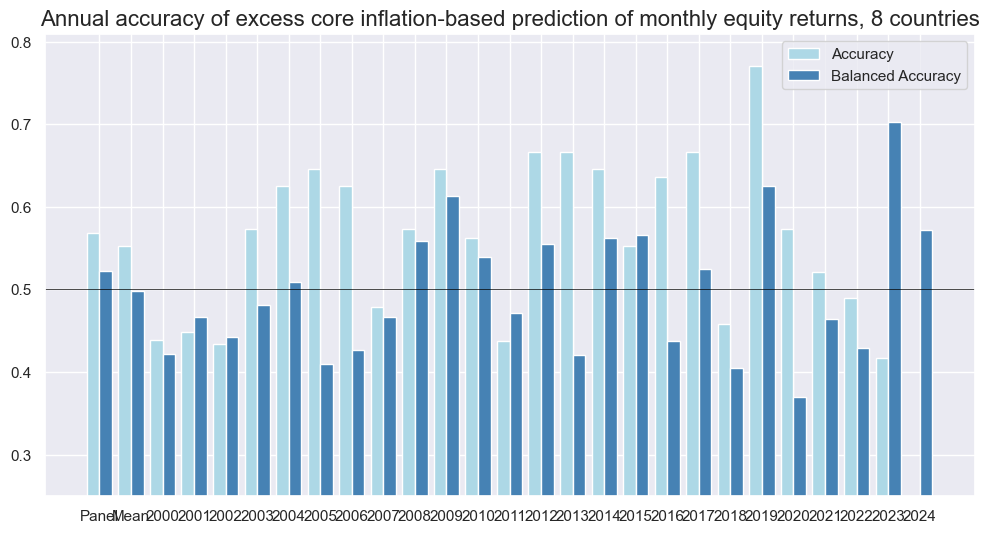

In [40]:
dix = dict_eqdi
srrx = dix["srr"]
srrx.accuracy_bars(
    type="years",
    title="Annual accuracy of excess core inflation-based prediction of monthly equity returns, 8 countries",
    size=(12, 6),
)

##### Naive PnL

In [41]:
dix = dict_eqdi

sigx = [dix["sig"]] + dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]

naive_pnl = msn.NaivePnL(
    dfx,
    ret=targ,
    sigs=sigx,
    cids=cidx,
    start="2000-01-01",
    blacklist=blax,
    #   bms=["USD_EQXR_NSA"],
)

for sig in sigx:
    naive_pnl.make_pnl(
        sig,
        sig_neg=True,
        sig_op="zn_score_pan",
        thresh=2,
        rebal_freq="monthly",
        vol_scale=10,
        rebal_slip=1,
        pnl_name=sig + "_PZN",
    )

naive_pnl.make_long_pnl(vol_scale=10, label="Long only")
dix["pnls"] = naive_pnl

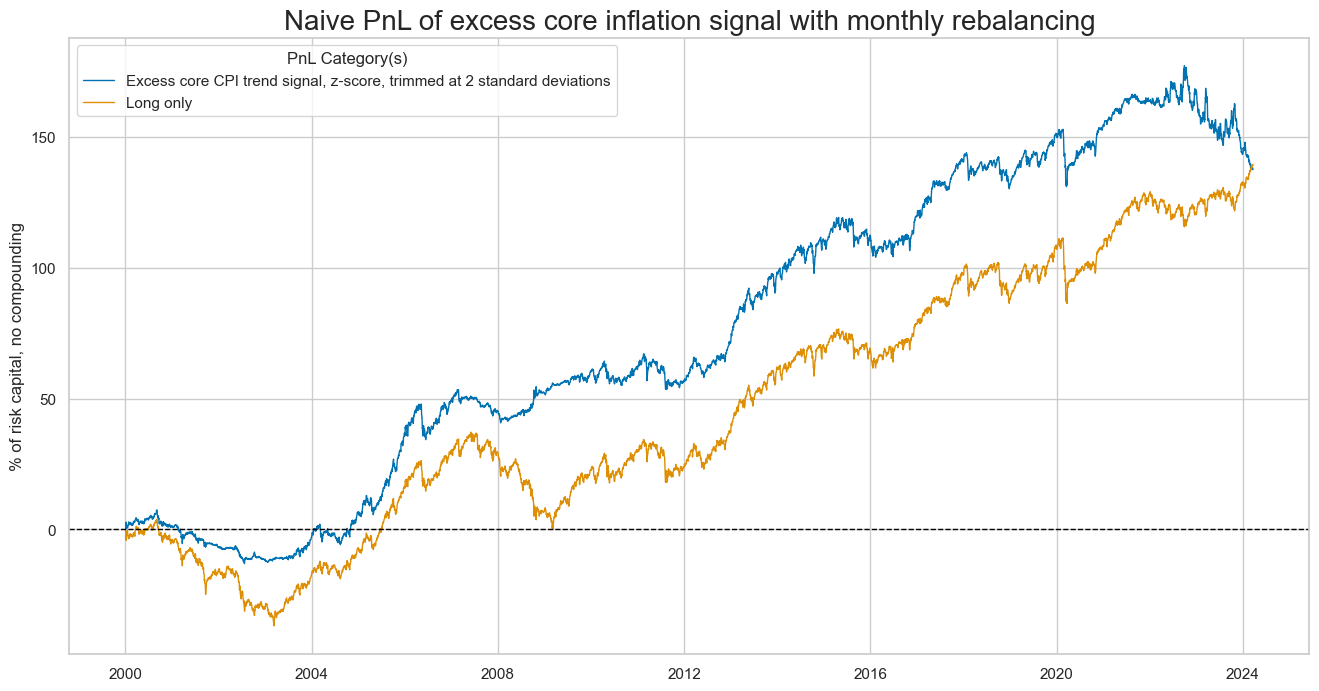

In [42]:
dix = dict_eqdi

sigx = ["CPIC_SJA_P6M6ML6AR_XR"]
naive_pnl = dix["pnls"]
pnls = [sig + "_PZN" for sig in sigx] + ["Long only"]

dict_labels = {
    "CPIC_SJA_P6M6ML6AR_XR_PZN": "Excess core CPI trend signal, z-score, trimmed at 2 standard deviations",
    "Long only": "Long only",
}

naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start="2000-01-01",
    title="Naive PnL of excess core inflation signal with monthly rebalancing",
    xcat_labels=dict_labels,
    figsize=(16, 8),
)

### FX returns

If central banks across developed markets are assumed to be similarly committed to their inflation targets, monetary policy in areas with higher excess inflation should have a greater bias towards tightening and their currencies should tend to outperform. Put simply, relative excess inflation should predict currency outperformance. We test this proposition for eight “smaller” developed countries: Australia, Canada, Switzerland, the UK, Japan, Norway, New Zealand, and Sweden. For all these currencies we measure 1-month FX forward returns against their natural benchmarks, i.e. either the U.S. dollar (AUD, CAD, JPY, NZD), the euro (CHF, NOK, SEK), or both (GBP).

As a trading signal, we use core inflation metric as above, focusing on a consistent core CPI definition that excludes the same food and energy prices for all countries. This is because, for the FX market, it is the excess core inflation differential between the base and the main reference currency that matters, and fair comparison calls for similarity in concept. Our targets are 1-month FX forward returns, on positions that are based on 10% vol targets (similar to the IRS case).


#### Directional

In [43]:
ios = [
    inf + "_" + xr for inf in infs for xr in ["XRvBM", "EXRvBM"]
]  # all inflation overshootings
ms = "CPIXFE_SJA_P6M6ML6AR_XRvBM"  # main signal
oths = list(set(ios) - set([ms]))  # other signals

dict_fxdi = {
    "sig": ms,
    "rivs": oths,
    "targ": "FXXR_VT10",
    "cidx": cids_dmfx,
    "black": fxblack,
    "srr": None,
    "pnls": None,
}

As expected, a positive relative excess inflation has been associated with higher or positive FX returns. The Macrosynergy panel test of predictive relation suggests that the relationship has been highly significant with a probability 99.8%.

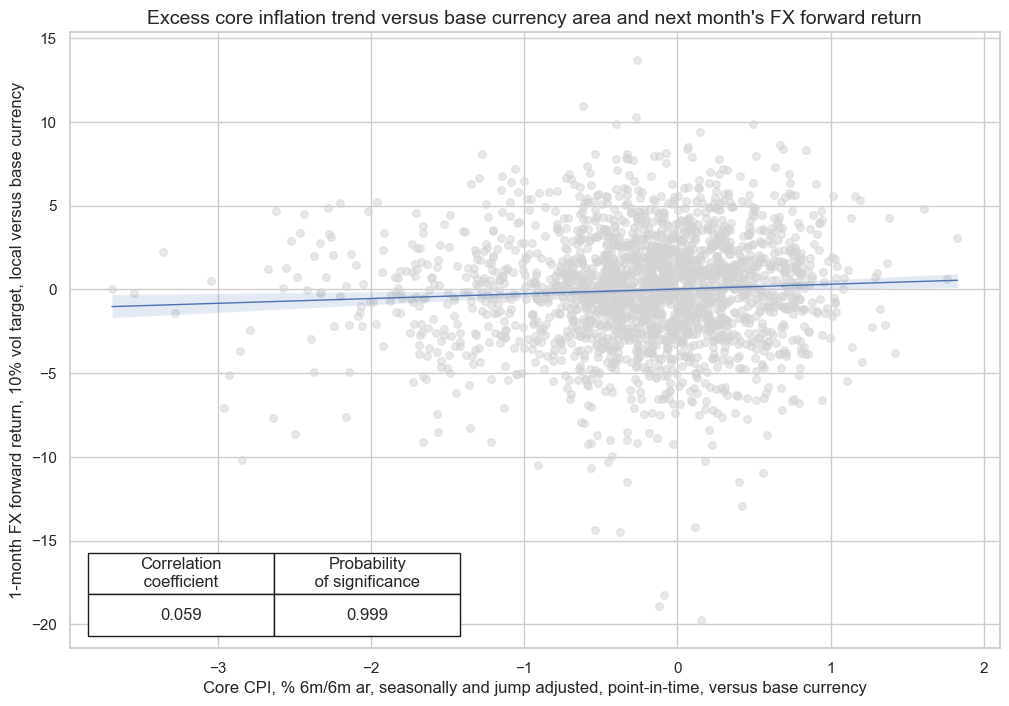

In [44]:
dix = dict_fxdi

sig = dix["sig"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]

crx = msp.CategoryRelations(
    dfx,
    xcats=[sig, targ],
    cids=cidx,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    start="2000-01-01",
    blacklist=blax,
    xcat_trims=[10, 30],
)
crx.reg_scatter(
    labels=False,
    coef_box="lower left",
    # separator=2011,
    xlab="Core CPI, % 6m/6m ar, seasonally and jump adjusted, point-in-time, versus base currency",
    ylab="1-month FX forward return, 10% vol target, local versus base currency",
    title="Excess core inflation trend versus base currency area and next month's FX forward return",
    size=(12, 8),
    prob_est="map",
)

##### Accuracy and correlation check

In [45]:
dix = dict_fxdi

sig = dix["sig"]
rivs = dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]

srr = mss.SignalReturnRelations(
    dfx,
    cids=cidx,
    sigs=[sig] + rivs,
    rets=targ,
    freqs="M",
    start="2000-01-01",
    blacklist=blax,
)

dix["srr"] = srr

The monthly balanced accuracy of relative excess inflation-based predictions of monthly FX returns has been more than 53% for the panel. Positive balanced accuracy prevailed in 70% of all years. Across alternative versions of the relative excess inflation signal accuracy (balanced) has been between 50.3% and 53.1%.

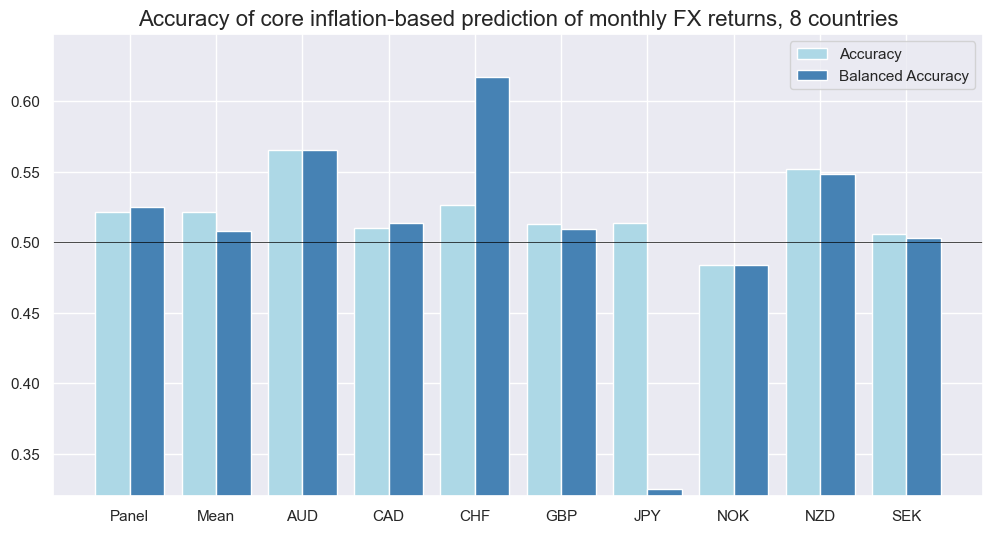

In [46]:
dix = dict_fxdi
srrx = dix["srr"]
srrx.accuracy_bars(
    type="cross_section",
    title="Accuracy of core inflation-based prediction of monthly FX returns, 8 countries",
    size=(12, 6),
)

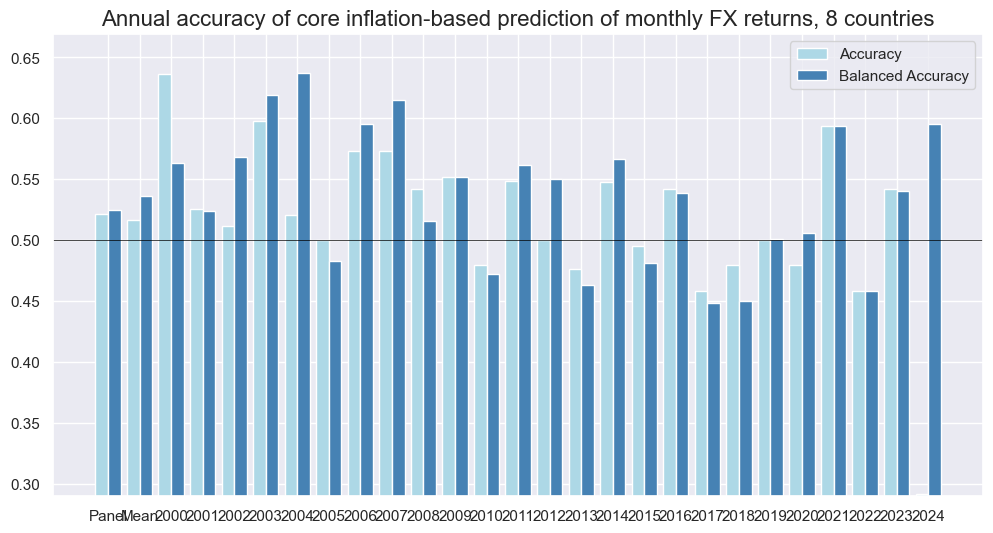

In [47]:
dix = dict_fxdi
srrx = dix["srr"]
srrx.accuracy_bars(
    type="years",
    title="Annual accuracy of core inflation-based prediction of monthly FX returns, 8 countries",
    size=(12, 6),
)

##### Naive PnL

In [48]:
dix = dict_fxdi

sigx = [dix["sig"]] + dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]

naive_pnl = msn.NaivePnL(
    dfx,
    ret=targ,
    sigs=sigx,
    cids=cidx,
    start="2000-01-01",
    blacklist=blax,
    #   bms=["USD_EQXR_NSA"],
)

for sig in sigx:
    naive_pnl.make_pnl(
        sig,
        sig_neg=False,
        sig_op="zn_score_pan",
        thresh=2,
        rebal_freq="monthly",
        vol_scale=10,
        rebal_slip=1,
        pnl_name=sig + "_PZN",
    )

naive_pnl.make_long_pnl(vol_scale=10, label="Long only")
dix["pnls"] = naive_pnl

Judging from the naïve PnL simulation, value generation has been reasonably consistent across time. Across the range of similar excess inflation signals Sharpe ratios have been in a range of 0.17 to 0.64. 

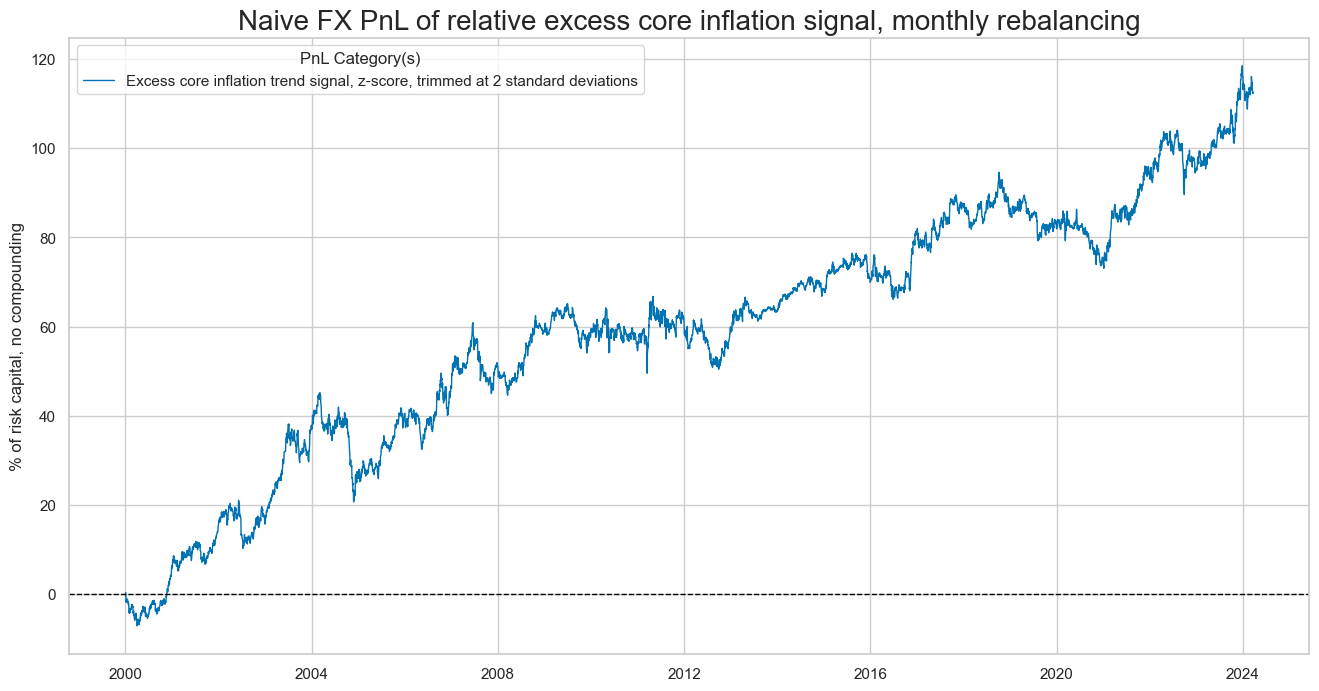

In [51]:
dix = dict_fxdi

sigx = [dix["sig"]]
naive_pnl = dix["pnls"]
pnls = [sig + "_PZN" for sig in sigx]  # + ["Long only"]

dict_labels={"CPIXFE_SJA_P6M6ML6AR_XRvBM_PZN": "Excess core inflation trend signal, z-score, trimmed at 2 standard deviations"}

naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start="2000-01-01",
    title="Naive FX PnL of relative excess core inflation signal, monthly rebalancing",
    xcat_labels=dict_labels,
    figsize=(16, 8),
)

In [52]:
dix = dict_fxdi

sigx = [dix["sig"]] + dix["rivs"]
naive_pnl = dix["pnls"]
pnls = [sig + "_PZN" for sig in sigx]

df_eval = naive_pnl.evaluate_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start="2000-01-01",
)
display(df_eval.transpose())

Return (pct ar) St. Dev. (pct ar)  \
xcat                                                                
CPIC_SJA_P6M6ML6AR_EXRvBM_PZN          2.869444              10.0   
CPIC_SJA_P6M6ML6AR_XRvBM_PZN           4.115621              10.0   
CPIXFE_SA_P1M1ML12_EXRvBM_PZN          2.132964              10.0   
CPIXFE_SA_P1M1ML12_XRvBM_PZN           2.971986              10.0   
CPIXFE_SJA_P6M6ML6AR_EXRvBM_PZN        4.525808              10.0   
CPIXFE_SJA_P6M6ML6AR_XRvBM_PZN         4.649126              10.0   
INFE2Y_JA_EXRvBM_PZN                   3.927467              10.0   
INFE2Y_JA_XRvBM_PZN                     5.03137              10.0   

                                Sharpe Ratio Sortino Ratio Max 21-day draw  \
xcat                                                                         
CPIC_SJA_P6M6ML6AR_EXRvBM_PZN       0.286944      0.410572      -11.516228   
CPIC_SJA_P6M6ML6AR_XRvBM_PZN        0.411562      0.590011       -9.555162   
CPIXFE_SA_P1M1ML12_EXRvBM_PZN       0.213296      0.302043      -12.411147   
CPIXFE_SA_P1M1ML12_XRvBM_PZN        0.297199      0.421443      -12.219169   
CPIXFE_SJA_P6M6ML6AR_EXRvBM_PZN     0.452581      0.657407      -11.615818   
CPIXFE_SJA_P6M6ML6AR_XRvBM_PZN      0.464913      0.668443      -10.569917   
INFE2Y_JA_EXRvBM_PZN                0.392747      0.572337       -11.64146   
INFE2Y_JA_XRvBM_PZN                 0.503137      0.727663        -9.65626   

                                Max 6-month draw Traded Months  
xcat                                                            
CPIC_SJA_P6M6ML6AR_EXRvBM_PZN         -18.751481           291  
CPIC_SJA_P6M6ML6AR_XRvBM_PZN          -12.196402           291  
CPIXFE_SA_P1M1ML12_EXRvBM_PZN         -20.433354           291  
CPIXFE_SA_P1M1ML12_XRvBM_PZN          -14.216943           291  
CPIXFE_SJA_P6M6ML6AR_EXRvBM_PZN       -18.622271           291  
CPIXFE_SJA_P6M6ML6AR_XRvBM_PZN        -15.750223           291  
INFE2Y_JA_EXRvBM_PZN                  -20.038592           291  
INFE2Y_JA_XRvBM_PZN                   -11.472741           291

#### Relative value

We can also test a “double relative” excess inflation signal for FX trading. The hypothesis is that among the eight smaller DM currencies those with higher relative excess inflation versus their base currencies outperform those with lower or negative relative excess inflation.

In [53]:
ios = [
    inf + "_" + xr for inf in infs for xr in ["XRvBMvDM", "EXRvBMvDM"]
]  # all inflation overshootings
ms = "CPIXFE_SJA_P6M6ML6AR_XRvBMvDM"  # main signal
oths = list(set(ios) - set([ms]))  # other signals

dict_fxrv = {
    "sig": ms,
    "rivs": oths,
    "targ": "FXXR_VT10vDM",
    "cidx": cids_dmfx,
    "black": fxblack,
    "srr": None,
    "pnls": None,
}

As in the previous cases, the positive correlation between double-relative excess inflation and relative FX returns is confirmed by the evidence. The Macrosynergy panel test assigns a 99.9% probability to the significance of the predictive relation over the past 23 years since 2000. The positive relation prevails for 7 of 8 small developed market currencies.

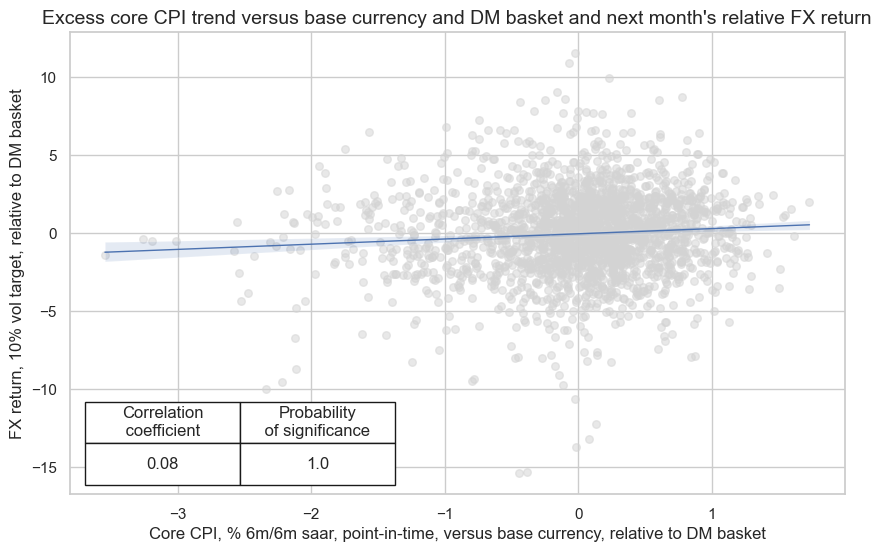

In [54]:
dix = dict_fxrv

sig = dix["sig"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]

crx = msp.CategoryRelations(
    dfx,
    xcats=[sig, targ],
    cids=cidx,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    start="2000-01-01",
    blacklist=blax,
    xcat_trims=[10, 25],
)
crx.reg_scatter(
    labels=False,
    coef_box="lower left",
    # separator=2011,
    xlab="Core CPI, % 6m/6m saar, point-in-time, versus base currency, relative to DM basket",
    ylab="FX return, 10% vol target, relative to DM basket",
    title="Excess core CPI trend versus base currency and DM basket and next month's relative FX return",
    size=(10, 6),
    prob_est="map",
)

#### Accuracy and correlation check

In [55]:
dix = dict_fxrv

sig = dix["sig"]
rivs = dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]

srr = mss.SignalReturnRelations(
    dfx,
    cids=cidx,
    sigs=[sig] + rivs,
    rets=targ,
    freqs="M",
    start="2000-01-01",
    blacklist=blax,
)

dix["srr"] = srr

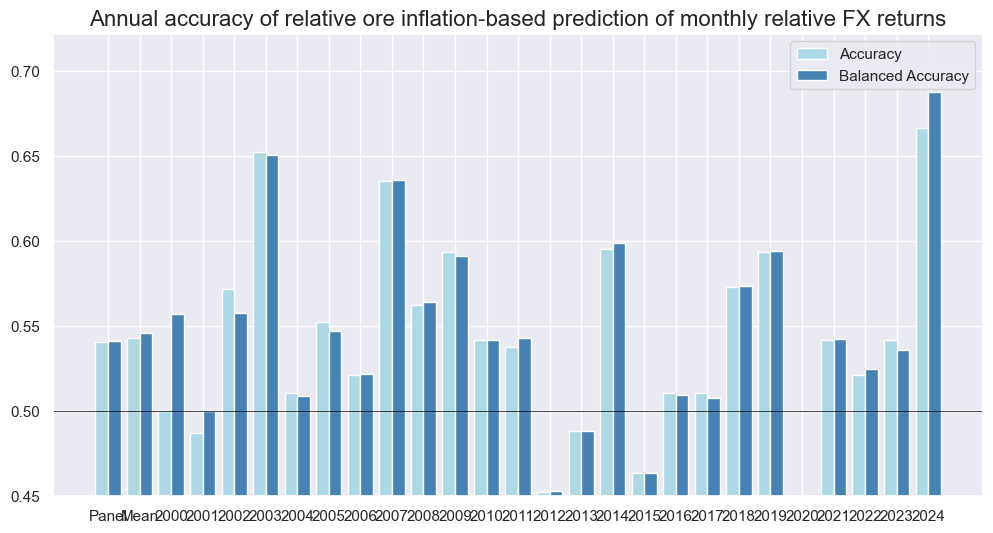

In [56]:
dix = dict_fxrv
srrx = dix["srr"]
srrx.accuracy_bars(
    type="years",
    title="Annual accuracy of relative ore inflation-based prediction of monthly relative FX returns",
    size=(12, 6),
)

#### Naive PnL

Naïve PnL generation has recorded a long-term Sharpe ratio of 0.5, but also has been extremely uneven across time. Most trading profits were produced from 2000 to 2007 and strategy returns flatlined from 2014. Across similar “double relative” excess inflation signals, naïve PnL Sharpe ratios have been between 0.35 and 0.67.

In [57]:
dix = dict_fxrv

sigx = [dix["sig"]] + dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]

naive_pnl = msn.NaivePnL(
    dfx,
    ret=targ,
    sigs=sigx,
    cids=cidx,
    start="2000-01-01",
    blacklist=blax,
    #   bms=["USD_EQXR_NSA"],
)

for sig in sigx:
    naive_pnl.make_pnl(
        sig,
        sig_neg=False,
        sig_op="zn_score_pan",
        thresh=2,
        rebal_freq="monthly",
        vol_scale=10,
        rebal_slip=1,
        pnl_name=sig + "_PZN",
    )

dix["pnls"] = naive_pnl

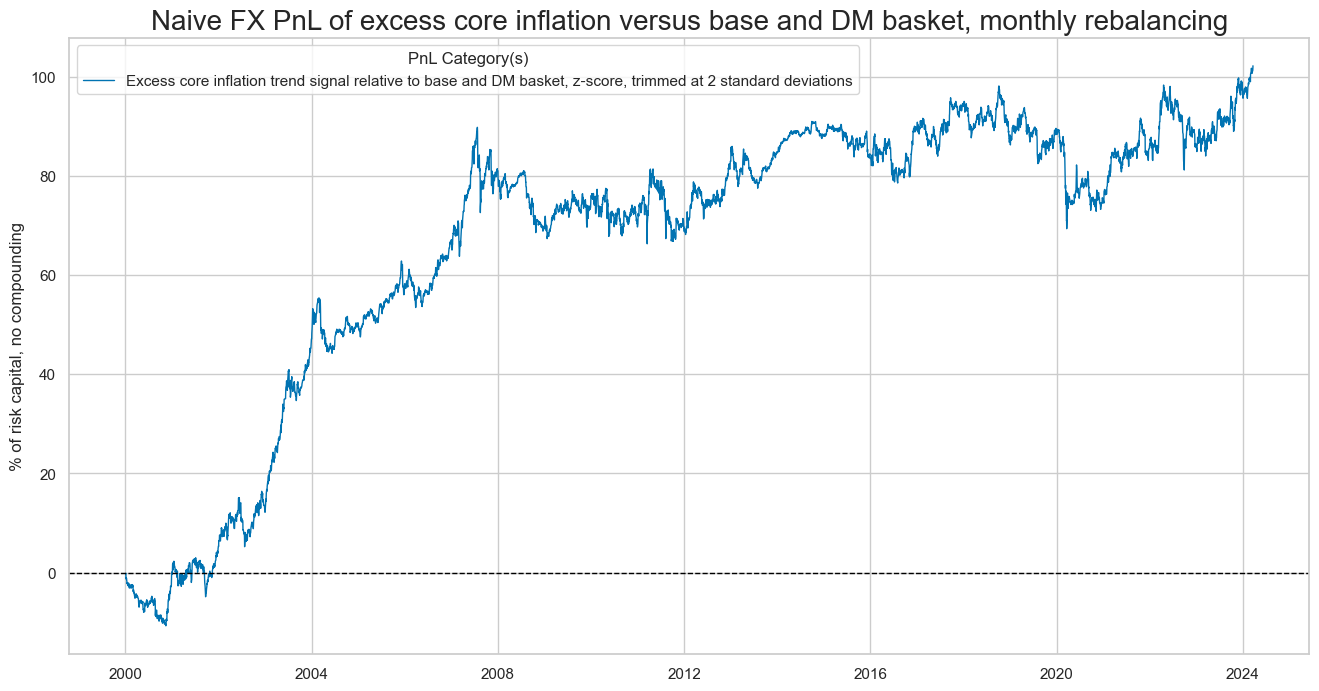

In [58]:
dix = dict_fxrv

sigx = [
    "CPIXFE_SA_P1M1ML12_XRvBMvDM",
]
naive_pnl = dix["pnls"]
pnls = [sig + "_PZN" for sig in sigx]
dict_labels={"CPIXFE_SA_P1M1ML12_XRvBMvDM_PZN": "Excess core inflation trend signal relative to base and DM basket, z-score, trimmed at 2 standard deviations"}

naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start="2000-01-01",
    title="Naive FX PnL of excess core inflation versus base and DM basket, monthly rebalancing",
    xcat_labels=dict_labels,
    figsize=(16, 8),
)

In [59]:
dix = dict_fxrv

sigx = [dix["sig"]] + dix["rivs"]
naive_pnl = dix["pnls"]
pnls = [sig + "_PZN" for sig in sigx]

df_eval = naive_pnl.evaluate_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start="2000-01-01",
)
display(df_eval.transpose())

Return (pct ar) St. Dev. (pct ar)  \
xcat                                                                   
CPIC_SJA_P6M6ML6AR_EXRvBMvDM_PZN          4.633405              10.0   
CPIC_SJA_P6M6ML6AR_XRvBMvDM_PZN           4.772051              10.0   
CPIXFE_SA_P1M1ML12_EXRvBMvDM_PZN          4.577839              10.0   
CPIXFE_SA_P1M1ML12_XRvBMvDM_PZN           4.222085              10.0   
CPIXFE_SJA_P6M6ML6AR_EXRvBMvDM_PZN        5.968112              10.0   
CPIXFE_SJA_P6M6ML6AR_XRvBMvDM_PZN         5.622914              10.0   
INFE2Y_JA_EXRvBMvDM_PZN                    5.46152              10.0   
INFE2Y_JA_XRvBMvDM_PZN                    4.821347              10.0   

                                   Sharpe Ratio Sortino Ratio Max 21-day draw  \
xcat                                                                            
CPIC_SJA_P6M6ML6AR_EXRvBMvDM_PZN        0.46334      0.668212      -15.847844   
CPIC_SJA_P6M6ML6AR_XRvBMvDM_PZN        0.477205      0.674373      -16.145435   
CPIXFE_SA_P1M1ML12_EXRvBMvDM_PZN       0.457784      0.645688      -17.426493   
CPIXFE_SA_P1M1ML12_XRvBMvDM_PZN        0.422208      0.585278      -18.587899   
CPIXFE_SJA_P6M6ML6AR_EXRvBMvDM_PZN     0.596811      0.858646      -15.149756   
CPIXFE_SJA_P6M6ML6AR_XRvBMvDM_PZN      0.562291      0.790476       -16.40413   
INFE2Y_JA_EXRvBMvDM_PZN                0.546152      0.786497      -16.303746   
INFE2Y_JA_XRvBMvDM_PZN                 0.482135      0.675019      -15.692521   

                                   Max 6-month draw Traded Months  
xcat                                                               
CPIC_SJA_P6M6ML6AR_EXRvBMvDM_PZN         -12.441103           291  
CPIC_SJA_P6M6ML6AR_XRvBMvDM_PZN          -13.484372           291  
CPIXFE_SA_P1M1ML12_EXRvBMvDM_PZN         -17.431815           291  
CPIXFE_SA_P1M1ML12_XRvBMvDM_PZN          -16.867697           291  
CPIXFE_SJA_P6M6ML6AR_EXRvBMvDM_PZN       -13.319823           291  
CPIXFE_SJA_P6M6ML6AR_XRvBMvDM_PZN        -13.460918           291  
INFE2Y_JA_EXRvBMvDM_PZN                  -12.124252           291  
INFE2Y_JA_XRvBMvDM_PZN                   -15.146164           291